# Trade selection using machine learning and candlestick patterns

## Content structure
1. Data preparation  
2. Feature engineering 
3. Variable selection (heuristic)
4. Model building and training 
5. Evaluation

## Data

The dataset consists of ~20,000 one-minute candlestick windows, each with 26 candlesticks. Candle 21 in each window is the signal candle, defined as one whose absolute percentage change satisfies

$$\left|\frac{\text{c}_\text{21} - \text{o}_\text{21}}{\text{o}_\text{21}}\right|\geq 0.04.$$

The target return for each window is defined as the percentage change from the opening price of the candle after the signal candle to the closing price of the fifth candle after the signal candle:

$$\text{return}=\frac{\text{c}_\text{26} - \text{o}_\text{22}}{\text{o}_\text{22}}.$$

Windows were extracted from one-minute data downloaded from [massive.com](https://massive.com)

For more details on how the windows were collected, see the appendix.

### Load candlestick windows

In [1]:
import os
import pandas as pd
import numpy as np

DATA_DIR = "data/windows"
windows_csv_names = os.listdir(DATA_DIR)
windows = []

for i, window_name in enumerate(windows_csv_names, start=1):
    w_df = pd.read_csv(os.path.join(DATA_DIR, window_name))
    ticker = window_name.split('_')[0]
    w_df['ticker'] = ticker
    windows.append(w_df)
    if i % 5000 == 0:
        print(f"{i} / {len(windows_csv_names)} windows loaded")

print(f"Number of windows: {len(windows)}")

5000 / 23163 windows loaded
10000 / 23163 windows loaded
15000 / 23163 windows loaded
20000 / 23163 windows loaded
Number of windows: 23163


### Clean and check windows

In [2]:
# Window parameters
N_CANDLES = 26 # Candles per window
N_CANDLES_BEFORE = 20 # Candles before signal candle
N_CANDLES_AFTER = 5 # Candles after signal candle
I_SIGNAL_CANDLE = 20 # Index signal candle
I_BUY_CANDLE = 21 # Index buy candle
I_SELL_CANDLE = 25 # Index sell candle
SIGNAL_THR = 0.04 # Threshold for absolute value of (c-o)/o for signal candle

In [3]:
# Example window
windows[0]

,v,vw,o,c,h,l,t,n,ticker
0,16771,27.7948,27.755,27.7900,27.840,27.7550,2025-02-21 15:48:00,242,AAOI
1,8376,27.7565,27.780,27.7650,27.790,27.7100,2025-02-21 15:49:00,124,AAOI
2,16524,27.7511,27.765,27.7500,27.780,27.7300,2025-02-21 15:50:00,221,AAOI
3,17292,27.7074,27.745,27.6900,27.750,27.6850,2025-02-21 15:51:00,246,AAOI
4,19804,27.6796,27.700,27.6740,27.710,27.6500,2025-02-21 15:52:00,246,AAOI
5,23903,27.6273,27.665,27.5850,27.703,27.5500,2025-02-21 15:53:00,250,AAOI
6,43268,27.5722,27.575,27.5750,27.603,27.5430,2025-02-21 15:54:00,471,AAOI
7,30053,27.4358,27.560,27.3300,27.560,27.3300,2025-02-21 15:55:00,328,AAOI
8,42423,27.2484,27.320,27.2251,27.320,27.1600,2025-02-21 15:56:00,513,AAOI
9,46713,27.2400,27.235,27.2900,27.300,27.2150,2025-02-21 15:57:00,566,AAOI


**Note:** The difference in time between candles (rows) doesn't have to be 1: candles with 0 trades/transactions are not included.

In [4]:
# Check missing values

has_na = [w_df.isna().any().any() for w_df in windows]
total_with_na = np.sum(has_na)
print(f"{total_with_na} out of {len(windows)} windows have missing values.")

0 out of 23163 windows have missing values.


In [5]:
# Convert time strings to timestamp
print(f"Type before: {type(windows[0]['t'][0])}")
for w_df in windows:
    w_df['t'] = pd.to_datetime(w_df['t'], errors='raise')
print(f"Type after: {type(windows[0]['t'][0])}")

Type before: <class 'str'>
Type after: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [6]:
# Check length of windows
lengths = [len(w_df) for w_df in windows]
bad_length_idx = [i for i, L in enumerate(lengths) if L != N_CANDLES]
print(f"{len(bad_length_idx)} windows have incorrect length.")

0 windows have incorrect length.


In [7]:
# Check (close-open)/open for signal candle
signal_perc = [(w_df['c'][I_SIGNAL_CANDLE] - w_df['o'][I_SIGNAL_CANDLE]) / w_df['o'][I_SIGNAL_CANDLE] for w_df in windows]
signal_perc_abs = np.abs(np.array(signal_perc))
bad_signal_idx = [i for i, perc_abs in enumerate(signal_perc_abs) if perc_abs < SIGNAL_THR]

print(f"Min: {np.min(signal_perc_abs):.3f}")
print(f"Max: {np.max(signal_perc_abs):.3f}")
print(f"{len(bad_signal_idx)} windows have bad signal candle.")

Min: 0.040
Max: 0.619
0 windows have bad signal candle.


In [8]:
# Check if dtypes are consistent
ref_dtypes = windows[0].dtypes

inconsistent_idx = []
for i, w_df in enumerate(windows):
    if not w_df.dtypes.equals(ref_dtypes):
        inconsistent_idx.append(i)

print(f"{len(inconsistent_idx)} windows have inconsistent dtypes.")

12332 windows have inconsistent dtypes.


In [9]:
# Check first problem window
print(f"First problem window:\n{windows[inconsistent_idx[0]][:].dtypes}\n")
print(f"Reference window:\n{ref_dtypes}\n")

First problem window:
v                float64
vw               float64
o                float64
c                float64
h                float64
l                float64
t         datetime64[ns]
n                  int64
ticker            object
dtype: object

Reference window:
v                  int64
vw               float64
o                float64
c                float64
h                float64
l                float64
t         datetime64[ns]
n                  int64
ticker            object
dtype: object



In [10]:
# Convert volume to int 
for i in inconsistent_idx:
    windows[i]['v'] = windows[i]['v'].round().astype('int64')

In [11]:
# Check inconsistent windows again
inconsistent_idx = []
for i, w_df in enumerate(windows):
    if not w_df.dtypes.equals(ref_dtypes):
        inconsistent_idx.append(i)

print(f"{len(inconsistent_idx)} windows have inconsistent dtypes.")

0 windows have inconsistent dtypes.


In [12]:
# Check chronological order for each window
not_monotonic_time = np.array([not windows[i]['t'].is_monotonic_increasing for i in range(len(windows))])
print(f"{sum(not_monotonic_time)} windows have incorrect time order")    

0 windows have incorrect time order


## Distributions of some features

In [13]:
# Sort windows based on time of signal candle
windows.sort(key=lambda w: w['t'].iloc[I_SIGNAL_CANDLE])

In [14]:
# Use first eda_frac to plot features, avoiding test data.
# (will use same fraction for train set later)
eda_frac = 0.7
n_eda_pre = int(len(windows) * eda_frac)

# Make sure the eda set ends at the transition to a new day
# (windows for same days may overlap)
day = windows[n_eda_pre-1]['t'].dt.dayofyear[0]
n_eda = n_eda_pre
for w_df in windows[n_eda:]:
    if w_df['t'].dt.dayofyear[0] > day:
        break
    else:
        n_eda += 1

windows_eda = [df.copy() for df in windows[:n_eda]]
windows_test = [df.copy() for df in windows[n_eda:]]

print(f'n_eda before adjusting for day transition: {n_eda_pre}')
print(f'n_eda after adjusting for day transition: {n_eda}')
print(f"Using {len(windows_eda)} out of {len(windows)} windows for eda/training ({eda_frac*100:.0f}%)")
print(f"Using {len(windows_test)} out of {len(windows)} windows for testing ({100 - eda_frac*100:.0f}%)")

n_eda before adjusting for day transition: 16214
n_eda after adjusting for day transition: 16297
Using 16297 out of 23163 windows for eda/training (70%)
Using 6866 out of 23163 windows for testing (30%)


In [15]:
start_date_eda = windows_eda[0]['t'].dt.date.iloc[0]
end_date_eda = windows_eda[-1]['t'].dt.date.iloc[0]
start_date_test = windows_test[0]['t'].dt.date.iloc[0]
end_date_test = windows_test[-1]['t'].dt.date.iloc[0]

print("Start date for EDA set:", start_date_eda)
print("End date for EDA set:", end_date_eda)
print("Start date for test set:", start_date_test)
print("End date for test set:", end_date_test )

Start date for EDA set: 2024-12-30
End date for EDA set: 2025-03-20
Start date for test set: 2025-03-21
End date for test set: 2025-04-17


In [16]:
import matplotlib.pyplot as plt

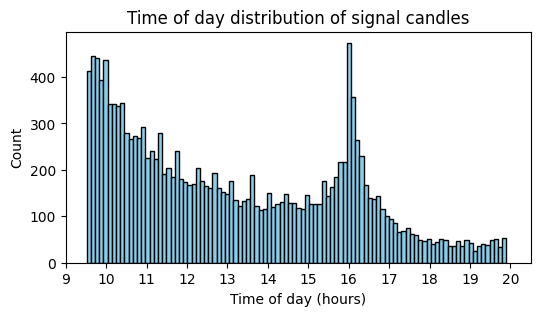

In [17]:
# Time of day distribution of signal candles
times_signal_h = []
for w_df in windows_eda:
    time_signal_h = w_df['t'][I_SIGNAL_CANDLE]
    hours = time_signal_h.hour + time_signal_h.minute/60 + time_signal_h.second/3600
    times_signal_h.append(hours)

plt.figure(figsize=(6,3))
plt.hist(times_signal_h, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Time of day (hours)')
plt.ylabel('Count')
plt.title('Time of day distribution of signal candles')
plt.xticks(range(8, 22, 1))
plt.xlim(9, 20.5)
plt.show()

**Note:** Due to the window collection process, more stocks qualified as the day progressed, which explains the peak at 16:00.

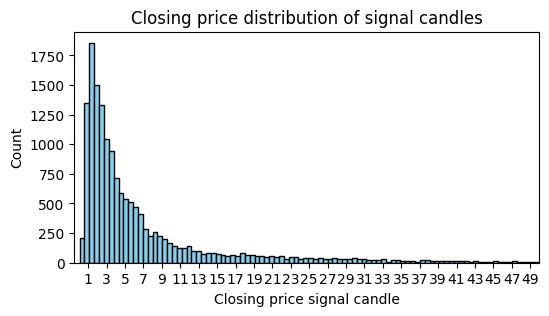

In [18]:
# Closing price distribution of signal candles
price_signals = np.array([w_df['c'].values[I_SIGNAL_CANDLE] for w_df in windows_eda])
plt.figure(figsize=(6,3))
plt.hist(price_signals, bins=1000, color='skyblue', edgecolor='black')
plt.xlabel('Closing price signal candle')
plt.ylabel('Count')
plt.title(f'Closing price distribution of signal candles')
plt.xticks(range(1, 50, 2))
plt.xlim(-0.5, 50)
plt.show()

In [19]:
mean_price_signals = np.mean(price_signals)   
median = np.median(price_signals) 
Min = np.min(price_signals)        
Max = np.max(price_signals)  
print(f"Summary of closing price for signal candles:")
print(f"Mean: {mean_price_signals:.2f}, Median: {median:.2f}, Min: {Min:.2f}, Max: {Max:.2f}")

Summary of closing price for signal candles:
Mean: 10.84, Median: 3.71, Min: 0.07, Max: 528.00


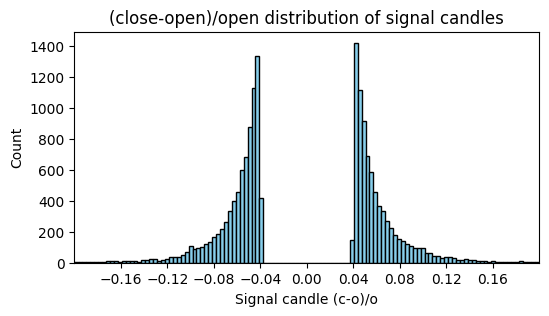

In [20]:
# (close - open) / open distribution of signal candles
signal_candle_perc = []
for w_df in windows_eda:
    signal_candle_perc.append((w_df['c'][I_SIGNAL_CANDLE] - w_df['o'][I_SIGNAL_CANDLE]) / w_df['o'][I_SIGNAL_CANDLE])
signal_candle_perc = np.array(signal_candle_perc)
plt.figure(figsize=(6,3))
plt.hist(signal_candle_perc, bins=350, color='skyblue', edgecolor='black')
plt.xlabel('Signal candle (c-o)/o')
plt.ylabel('Count')
plt.title(f'(close-open)/open distribution of signal candles')
plt.xticks(np.arange(-0.16, 0.16 + 0.01, 0.04))
plt.xlim(-0.2, 0.2)
plt.show()

**Figure:** We can see that the windows are consciously chosen: every signal candle satisfies $|(c-o)/o| \geq 0.04$.

In [21]:
print("Signal candle (c-o)/o summary:")
print(f"Negative candles: min: {np.min(signal_candle_perc):.3f}, max: {np.max(signal_candle_perc[signal_candle_perc < 0]):.3f}")
print(f"Positive candles: min: {np.min(signal_candle_perc[signal_candle_perc > 0]):.3f}, max: {np.max(signal_candle_perc):.3f}")

Signal candle (c-o)/o summary:
Negative candles: min: -0.619, max: -0.040
Positive candles: min: 0.040, max: 0.565


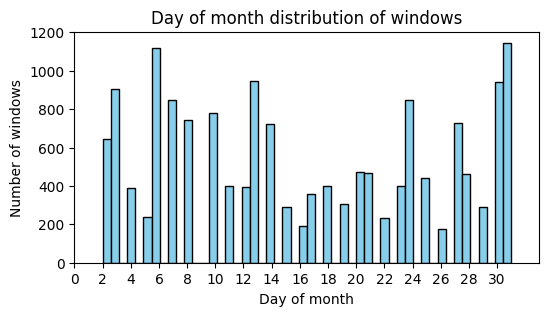

In [22]:
# Day of month distribution of signal candles (windows)
dayofmonths = []
for w_df in windows_eda:
    dayofmonths.append(w_df['t'].iloc[0].day)
    
plt.figure(figsize=(6,3))
plt.hist(dayofmonths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Day of month')
plt.ylabel('Number of windows')
plt.title(f'Day of month distribution of windows')
plt.xticks(np.arange(0, 31, 2))
plt.xlim(0, 33)
plt.show()

In [23]:
# Returns for windows in EDA set
c_stack = np.stack([w_df['c'] for w_df in windows_eda])
o_stack = np.stack([w_df['o'] for w_df in windows_eda])

returns_eda = (c_stack[:, I_SELL_CANDLE] - o_stack[:, I_BUY_CANDLE]) / o_stack[:, I_BUY_CANDLE]
baseline_eda = np.mean(returns_eda)
print(f"Mean return for EDA set): {baseline_eda:.10f}")

Mean return for EDA set): 0.0000808393


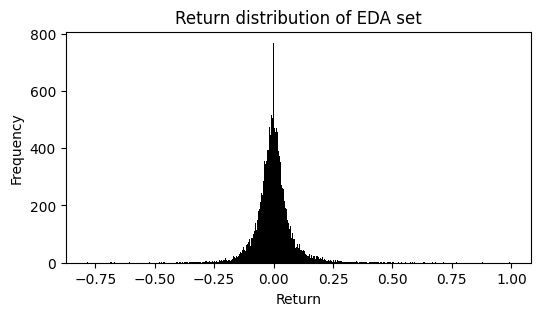

In [24]:
# Return distribution of EDA set
plt.figure(figsize=(6,3))
plt.hist(returns_eda, bins=500, color='black', label="top10")
plt.title("Return distribution of EDA set")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

## Derive time features

In [25]:
n_pred_candles = len(windows[0].iloc[:I_BUY_CANDLE])
n_features_per_candle = len(windows[0].columns) - 1 # Will not use ticker as feature

print(f"Each window has {n_pred_candles} candles that are used for predictions")
print(f"Each candle has {n_features_per_candle} features (v, vw, o, c, h, l, t, n)")
print(f"So each window has {n_pred_candles} * {n_features_per_candle} = {n_pred_candles * n_features_per_candle} raw features")

Each window has 21 candles that are used for predictions
Each candle has 8 features (v, vw, o, c, h, l, t, n)
So each window has 21 * 8 = 168 raw features


In [26]:
windows[0].dtypes

v                  int64
vw               float64
o                float64
c                float64
h                float64
l                float64
t         datetime64[ns]
n                  int64
ticker            object
dtype: object

In [27]:
# Derive time features from 't'
for w_df in windows:
    w_df['minute'] = w_df['t'].dt.minute
    w_df['hour'] = w_df['t'].dt.hour
    w_df['dayofweek'] = w_df['t'].dt.dayofweek
    w_df['dayofmonth'] = w_df['t'].dt.day
    w_df['dayofyear'] = w_df['t'].dt.dayofyear
    w_df['month'] = w_df['t'].dt.month

    # 'halt': is 1 if > 1min between signal candle and buy candle (i.e, the candle after the signal candle)
    w_df['halt'] = (w_df['t'].iloc[I_BUY_CANDLE] - w_df['t'].iloc[I_SIGNAL_CANDLE]) > pd.Timedelta(minutes=1)

print(f"Added time features (using windows[0].iloc[0]) as example):"
      f"\nminute: {windows[0]['minute'].iloc[0]}\nhour: {windows[0]['hour'].iloc[0]}"
      f"\ndayofweek: {windows[0]['dayofweek'].iloc[0]}\ndayofmonth: {windows[0]['dayofmonth'].iloc[0]}"
      f"\ndayofyear: {windows[0]['dayofyear'].iloc[0]}\nmonth: {windows[0]['month'].iloc[0]}"
      f"\nhalt: {windows[0]['halt'].iloc[0]}")

Added time features (using windows[0].iloc[0]) as example):
minute: 11
hour: 9
dayofweek: 0
dayofmonth: 30
dayofyear: 365
month: 12
halt: False


## Flatten windows and create feature dictionary

In [28]:
# Flatten windows
flattened_windows = []
skip_cols = ['ticker', 't', 'dayofweek', 'dayofmonth', 'dayofyear', 'month', 'halt'] 

for w_df in windows:
    flattened = w_df.iloc[:I_BUY_CANDLE].drop(columns=skip_cols, errors='raise').values.flatten(order='F')
    
    # features that are constant in each window
    dayofweek = w_df['dayofweek'].iloc[0]
    dayofmonth = w_df['dayofmonth'][0]
    dayofyear = w_df['dayofyear'].iloc[0]
    month = w_df['month'].iloc[0]
    halt = w_df['halt'].iloc[0]
    
    flattened_window = np.array(list(flattened) + [dayofweek, dayofmonth, dayofyear, month, halt])
    flattened_windows.append(flattened_window)

# Number of columns that come from feature 'families' for which all candles (up to signal) are used, e.g 'c', 'o', 'v', 'vw'
# (used for creating feature dictionary)
n_full_cols = flattened.shape[0]

flattened_windows_raw = np.array(flattened_windows)
print("Number of rows (windows) in flattened_windows_raw:", flattened_windows_raw.shape[0])
print("Number of columns (features) for flattened_windows_raw:", flattened_windows_raw.shape[1])

Number of rows (windows) in flattened_windows_raw: 23163
Number of columns (features) for flattened_windows_raw: 194


In [29]:
# Create feature dictionary for columns of flattened windows
headers_full_cols = ['v', 'vw', 'o', 'c', 'h', 'l', 'n', 'minute', 'hour']
dict_raw_features = {}

# First column
dict_raw_features[0] = 'rtn'

# Columns with whose all rows are used
for i in range(1, n_full_cols + 1):  
    if (i - 1) % (N_CANDLES_BEFORE + 1) == 0:
        # change header
        header = headers_full_cols[i // (N_CANDLES_BEFORE + 1)]
    candle = (i - 1) % (N_CANDLES_BEFORE + 1)
    dict_raw_features[i] = f"{header}_candle_{candle + 1}"

# Columns with only one value
for i in range(len(skip_cols) - 2): # skipping ticker (first) 'rtn' already first col, 't' is not numeric
    dict_raw_features[i + n_full_cols + 1] = f"{skip_cols[i + 2]}" # +2 to skip ticker and t (the first two names in skip_cols)

print(f'Number of features (incl. return) in dictionary for raw features: {len(dict_raw_features)}')

Number of features (incl. return) in dictionary for raw features: 195


## Screening, raw features

Checking correlations and decision tree R^2 scores for each individual (raw) feature vs. return.

In [30]:
# Use first n_eda for screening
df_flattened_windows_eda = pd.DataFrame(flattened_windows_raw[:n_eda, :])

# Insert return at first col
df_flattened_windows_eda.insert(0, 'rtn' , returns_eda)
df_flattened_windows_eda.columns = range(len(df_flattened_windows_eda.columns))

df_flattened_windows_eda.shape

(16297, 195)

In [31]:
# Pearson and Spearman correlations for all columns vs first column (target)
pearsons = df_flattened_windows_eda.corr(method='pearson').iloc[0]
spearmans = df_flattened_windows_eda.corr(method='spearman').iloc[0]

pearsons_abs = pearsons.abs()
spearmans_abs = spearmans.abs()

In [32]:
# Print top correlations

top_n_corr = 20
top_n_pear_abs = pearsons_abs.sort_values(ascending=False).head(top_n_corr)
top_n_pear = pearsons[top_n_pear_abs.index]

top_n_spear_abs = spearmans_abs.sort_values(ascending=False).head(top_n_corr)
top_n_spear = spearmans[top_n_spear_abs.index]

print("".ljust(4), f"Top {top_n_corr} Pearson:".ljust(50), f"Top {top_n_corr} Spearman:".ljust(12))

print("".ljust(40), "Pearson".ljust(50), "Spearman")
for i in range(top_n_corr):
    print(f"{i+1}".ljust(4),\
          f"Column {top_n_pear.index[i]} ({dict_raw_features[top_n_pear.index[i]]})".ljust(35),\
          f"{top_n_pear.iloc[i]:.4f}".ljust(14),\
          f"Column {top_n_spear.index[i]} ({dict_raw_features[top_n_spear.index[i]]})".ljust(35),\
          f"{top_n_spear.iloc[i]:.4f}")

     Top 20 Pearson:                                    Top 20 Spearman:
                                         Pearson                                            Spearman
1    Column 0 (rtn)                      1.0000         Column 0 (rtn)                      1.0000
2    Column 133 (n_candle_7)             -0.0192        Column 145 (n_candle_19)            -0.0604
3    Column 145 (n_candle_19)            -0.0180        Column 146 (n_candle_20)            -0.0597
4    Column 131 (n_candle_5)             -0.0180        Column 144 (n_candle_18)            -0.0581
5    Column 186 (hour_candle_18)         0.0169         Column 143 (n_candle_17)            -0.0535
6    Column 184 (hour_candle_16)         0.0167         Column 19 (v_candle_19)             -0.0521
7    Column 187 (hour_candle_19)         0.0167         Column 18 (v_candle_18)             -0.0515
8    Column 185 (hour_candle_17)         0.0167         Column 20 (v_candle_20)             -0.0510
9    Column 181 (hour_candl

n, hour, v possibly interesting

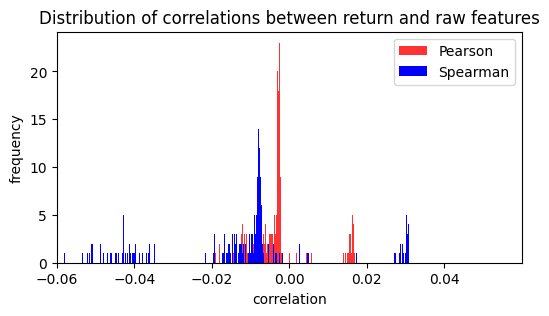

In [33]:
# Histogram of correlations
plt.figure(figsize=(6,3))
plt.hist(pearsons, bins=4000, color='red', alpha=0.8, label="Pearson")
plt.hist(spearmans, bins=4000, color='blue', label="Spearman")
plt.xlabel('correlation')
plt.ylabel('frequency')
plt.title(f'Distribution of correlations between return and raw features')
plt.xticks(np.arange(-0.06, 0.06, 0.02))
plt.xlim(-0.06, 0.06)
plt.legend()
plt.show()

In [34]:
# Decision tree screening
from sklearn.tree import DecisionTreeRegressor

X = df_flattened_windows_eda.iloc[:, 1:] # flattened windows without return
y = df_flattened_windows_eda.iloc[:, 0] # return

results_d1 = {}
results_d2 = {}

# custom depth
d = 10
results_d = {}

for col in X.columns:
    tree_d1 = DecisionTreeRegressor(max_depth=1)
    tree_d1.fit(X[[col]], y)  # X[[col]] keeps it as 2D
    score_d1 = tree_d1.score(X[[col]], y)  # R^2 score
    results_d1[col] = score_d1
    
    tree_d2 = DecisionTreeRegressor(max_depth=2)
    tree_d2.fit(X[[col]], y)
    score_d2 = tree_d2.score(X[[col]], y) 
    results_d2[col] = score_d2   

    tree_d = DecisionTreeRegressor(max_depth=d)
    tree_d.fit(X[[col]], y)
    score_d = tree_d.score(X[[col]], y)
    results_d[col] = score_d

In [35]:
n_top = 20


d1_sorted = sorted(results_d1.items(), key=lambda x: x[1], reverse=True)
top_d1 = d1_sorted[:n_top]

d2_sorted = sorted(results_d2.items(), key=lambda x: x[1], reverse=True)
top_d2 = d2_sorted[:n_top]

d_sorted = sorted(results_d.items(), key=lambda x: x[1], reverse=True)
top_d = d_sorted[:n_top]

print(f"Top {n_top} R^2 scores from depth 1, depth 2 and depth {d} decision trees:\n")
print("".ljust(9), "Depth 1".ljust(25), "Depth 2".ljust(25), f"Depth {d}\n")
for i in range(n_top):
    print(f"{i+1}".ljust(4),
          f"{dict_raw_features[top_d1[i][0]]}".ljust(15), f"{top_d1[i][1]:.3f}".ljust(9),\
          f"{dict_raw_features[top_d2[i][0]]}".ljust(15), f"{top_d2[i][1]:.3f}".ljust(9),\
          f"{dict_raw_features[top_d[i][0]]}".ljust(15), f"{top_d[i][1]:.3f}")

Top 20 R^2 scores from depth 1, depth 2 and depth 10 decision trees:

          Depth 1                   Depth 2                   Depth 10

1    l_candle_13     0.016     c_candle_13     0.018     vw_candle_13    0.109
2    c_candle_13     0.015     l_candle_13     0.018     l_candle_1      0.086
3    vw_candle_13    0.015     o_candle_13     0.016     vw_candle_14    0.081
4    o_candle_13     0.015     c_candle_12     0.016     l_candle_2      0.080
5    c_candle_12     0.014     vw_candle_13    0.016     o_candle_14     0.079
6    l_candle_14     0.014     c_candle_14     0.016     c_candle_14     0.078
7    o_candle_14     0.014     l_candle_18     0.016     o_candle_15     0.075
8    vw_candle_14    0.014     o_candle_14     0.016     vw_candle_12    0.075
9    c_candle_14     0.013     l_candle_14     0.016     l_candle_13     0.073
10   l_candle_18     0.013     vw_candle_14    0.016     o_candle_12     0.072
11   h_candle_14     0.013     l_candle_12     0.015     v_candle_19

vw, o, h c, l possibly interesting

## Feature engineering

Each engineered feature belongs to a feature family. Feature families are named with the prefix **E_** and can contain one or more features.

In [36]:
# Function to check engineered features
def check_nans_infs(array, shape=True):
    n_infs = np.sum(np.isinf(array))
    n_nans = np.sum(np.isnan(array))
    print("infs:", n_infs)
    print("nans:", n_nans)
    if shape:
        print(f"Shape: {array.shape}")
    if n_infs > 0 or n_nans > 0:
        raise ValueError(f"Array contains {n_nans} NaNs and {n_infs} Infs")

In [37]:
def slope_parts(stack, n_parts):
    """
    stack has shape (len(windows), m), where m >= I_SIGNAL_CANDLE.
    Divide axis 1 into n_parts, return slope for each part and each row.

    Slices each part from the end, so the last candles (closest to the signal candle) are prioritized.
    If I_SIGNAL_CANDLE % n_parts != 0, candles furthest away from signal are ignored.
    """
    n_candles = I_SIGNAL_CANDLE // n_parts
    x = np.arange(n_candles)
    x_mean = x.mean()
    x_ssd = np.sum((x - x_mean)**2) # sum of squared deviations
    slopes = np.zeros((len(windows_e), n_parts))
    for i in range(n_parts):
        part = stack[:, I_SIGNAL_CANDLE - (i+1) * n_candles:I_SIGNAL_CANDLE - i * n_candles]
        slopes[:, i] = np.sum((part - part.mean(axis=1).reshape(-1, 1)) * (x - x_mean), axis=1) / x_ssd
    return slopes

In [38]:
def normalize_stack(stack, n_candles, eps=1e-8):
    """ 
    Normalize stack using the formula (x - x_min) / (x_max - x_min).
    stack has shape (n_windows, n_candles)
    """
    stack_min = np.min(stack[:, :n_candles], axis=1).reshape(-1, 1)
    stack_max = np.max(stack[:, :n_candles], axis=1).reshape(-1, 1)
    normalized_stack = (stack[:, :n_candles] - stack_min) / np.where(stack_max - stack_min == 0, eps, stack_max - stack_min)
    return normalized_stack

In [39]:
def crtn_slopes(price_setting, log=True):
    """
    input shape: (n_windows, n_candles)
    Output shapes:
    crtn: (n_windows, n_candles - 1),
    crtn_slope_1: (n_windows, 1)
    crtn_slope_2: (n_windows, 2)
    crtn_slope_4: (n_windows, 4)

    Given price_setting:
    crtn: cumulative returns from candle 2 up to candle n_candles.
    crtn_slope_1: Slope for full window
    crtn_slope_2: Slopes for first and second halves
    crtn_slope_4: Slopes for all 1/4'th parts of the window    
    """
    price_stack = np.stack([w_df[price_setting].to_numpy() for w_df in windows_e])
    price_0 = price_stack[:, 0].reshape(-1, 1)
    crtn = np.log(price_stack / price_0)
    if not log:
        crtn = None
        
    crtn_to_slope = crtn[:, :-1] # don't use signal candle for slopes
    crtn_slope_1 = slope_parts(crtn_to_slope, n_parts=1)
    crtn_slope_2 = slope_parts(crtn_to_slope, n_parts=2)
    crtn_slope_4 = slope_parts(crtn_to_slope, n_parts=4)
    
    # Skip first col since log(price0/price0) = 0
    return crtn[:, 1:], crtn_slope_1, crtn_slope_2, crtn_slope_4

In [40]:
from dataclasses import dataclass

@dataclass
class FeatureFamily:
    name: str
    n_features: int
    features: np.ndarray
    temporal: bool = False

In [41]:
feature_families = {}

def register_feature(name, n_expected, array, temporal=False):
    """
    n_expected mostly for checking consistency between the number of features we
    expect array to have and the actual number of features.
    """
    check_nans_infs(array)
    n_actual = array.shape[1]
    if n_expected != n_actual:
        raise ValueError(f"{name}: expected {n_expected} timesteps, got {n_actual}")
    feature_families[name] = FeatureFamily(name, n_expected, array, temporal)

In [42]:
# Make sure to use only candles 1, ...., signal_candle for feature engineering
windows_e = [w_df.iloc[:I_SIGNAL_CANDLE + 1].copy() for w_df in windows]

In [43]:
# cumulative return from candle 2 to signal candle, price_setting = 'o'
# name: 'E_crtn_o'
n_crtn_o = 20

# Cumulative rtn slope for full window, not incl. signal
# name: 'E_crtn_o_slope_1'
n_crtn_o_slope_1 = 1

# Cumulative rtn slope 2 parts, not incl. signal
# name: 'E_crtn_o_slope_2'
n_crtn_o_slope_2 = 2

# Cumulative rtn slope 4 parts, not incl. signal
# name: 'E_crtn_o_slope_4'
n_crtn_o_slope_4 = 4

crtn_o, crtn_o_slope_1, crtn_o_slope_2, crtn_o_slope_4 = crtn_slopes(price_setting='o')

register_feature('E_crtn_o', n_crtn_o, crtn_o, temporal=True)
register_feature('E_crtn_o_slope_1', n_crtn_o_slope_1, crtn_o_slope_1)
register_feature('E_crtn_o_slope_2', n_crtn_o_slope_2, crtn_o_slope_2, temporal=True)
register_feature('E_crtn_o_slope_4', n_crtn_o_slope_4, crtn_o_slope_4, temporal=True)

infs: 0
nans: 0
Shape: (23163, 20)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 2)
infs: 0
nans: 0
Shape: (23163, 4)


In [44]:
# cumulative return from candle 2 to signal candle, price_setting = 'c'
# name: 'E_crtn_c'
n_crtn_c = 20

# Cumulative rtn slope for full window, not incl. signal
# name: 'E_crtn_c_slope_1'
n_crtn_c_slope_1 = 1

# Cumulative rtn slope 2 parts, not incl. signal
# name: 'E_crtn_c_slope_2'
n_crtn_c_slope_2 = 2

# Cumulative rtn slope 4 parts, not incl. signal
# name: 'E_crtn_c_slope_4'
n_crtn_c_slope_4 = 4

crtn_c, crtn_c_slope_1, crtn_c_slope_2, crtn_c_slope_4 = crtn_slopes(price_setting='c')

register_feature('E_crtn_c', n_crtn_c, crtn_c, temporal=True)
register_feature('E_crtn_c_slope_1', n_crtn_c_slope_1, crtn_c_slope_1)
register_feature('E_crtn_c_slope_2', n_crtn_c_slope_2, crtn_c_slope_2, temporal=True)
register_feature('E_crtn_c_slope_4', n_crtn_c_slope_4, crtn_c_slope_4, temporal=True)

infs: 0
nans: 0
Shape: (23163, 20)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 2)
infs: 0
nans: 0
Shape: (23163, 4)


In [45]:
# cumulative return from candle 2 to signal candle, price_setting = 'h'
# name: 'E_crtn_h'
n_crtn_h = 20

# Cumulative rtn slope for full window, not incl. signal
# name: 'E_crtn_h_slope_1'
n_crtn_h_slope_1 = 1

# Cumulative rtn slope 2 parts, not incl. signal
# name: 'E_crtn_h_slope_2'
n_crtn_h_slope_2 = 2

# Cumulative rtn slope 4 parts, not incl. signal
# name: 'E_crtn_h_slope_4'
n_crtn_h_slope_4 = 4

crtn_h, crtn_h_slope_1, crtn_h_slope_2, crtn_h_slope_4 = crtn_slopes(price_setting='h')

register_feature('E_crtn_h', n_crtn_h, crtn_h, temporal=True)
register_feature('E_crtn_h_slope_1', n_crtn_h_slope_1, crtn_h_slope_1)
register_feature('E_crtn_h_slope_2', n_crtn_h_slope_2, crtn_h_slope_2, temporal=True)
register_feature('E_crtn_h_slope_4', n_crtn_h_slope_4, crtn_h_slope_4, temporal=True)

infs: 0
nans: 0
Shape: (23163, 20)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 2)
infs: 0
nans: 0
Shape: (23163, 4)


In [46]:
# cumulative return from candle 2 to signal candle, price_setting = 'l'
# name: 'E_crtn_l'
n_crtn_l = 20

# Cumulative rtn slope for full window, not incl. signal
# name: 'E_crtn_l_slope_1'
n_crtn_l_slope_1 = 1

# Cumulative rtn slope 2 parts, not incl. signal
# name: 'E_crtn_l_slope_2'
n_crtn_l_slope_2 = 2

# Cumulative rtn slope 4 parts, not incl. signal
# name: 'E_crtn_l_slope_4'
n_crtn_l_slope_4 = 4

crtn_l, crtn_l_slope_1, crtn_l_slope_2, crtn_l_slope_4 = crtn_slopes(price_setting='l')

register_feature('E_crtn_l', n_crtn_l, crtn_l, temporal=True)
register_feature('E_crtn_l_slope_1', n_crtn_l_slope_1, crtn_l_slope_1)
register_feature('E_crtn_l_slope_2', n_crtn_l_slope_2, crtn_l_slope_2, temporal=True)
register_feature('E_crtn_l_slope_4', n_crtn_l_slope_4, crtn_l_slope_4, temporal=True)

infs: 0
nans: 0
Shape: (23163, 20)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 2)
infs: 0
nans: 0
Shape: (23163, 4)


In [47]:
# close to close log return for candles 2, ... , signal_candle (first candle has no previous)
# name: E_c2c_rtn   
n_c2c_rtn = 20 # 20 candles

closes = np.stack([w_df['c'].to_numpy() for w_df in windows_e])
c2c_rtn = np.log(closes[:, 1:I_BUY_CANDLE] / closes[:, :I_BUY_CANDLE-1])

register_feature('E_c2c_rtn', n_c2c_rtn, c2c_rtn, temporal=True)

infs: 0
nans: 0
Shape: (23163, 20)


In [48]:
# Rel. dist to vwap: (price - vwap) / vwap for each candle
# name: E_vw_dist
n_vw_dist = 21

price_setting = 'h'

vw_stack = np.stack([w_df['vw'].to_numpy() for w_df in windows_e])
price_stack = np.stack([w_df[price_setting].to_numpy() for w_df in windows_e])
vw_dist = (price_stack[:, :I_BUY_CANDLE] - vw_stack[:, :I_BUY_CANDLE]) / vw_stack[:, :I_BUY_CANDLE]

register_feature('E_vw_dist', n_vw_dist, vw_dist, temporal=True)

infs: 0
nans: 0
Shape: (23163, 21)


In [49]:
# Close signal candle relative to high, low:
# (close_signal_candle - low_prevs) / (high_prevs - low_prevs)
# name: E_signal_high_low
n_signal_high_low = 1

n_prev = 20

lows = np.stack([w_df['l'].to_numpy() for w_df in windows_e])
lows_prev = np.min(lows[:, I_SIGNAL_CANDLE - n_prev:I_SIGNAL_CANDLE], axis=1)
highs = np.stack([w_df['h'].to_numpy() for w_df in windows_e])
highs_prev = np.max(highs[:, I_SIGNAL_CANDLE - n_prev:I_SIGNAL_CANDLE], axis=1)
signal_close = np.stack([w_df['c'].to_numpy()[I_SIGNAL_CANDLE] for w_df in windows_e])

signal_high_low = (signal_close - lows_prev) / (highs_prev - lows_prev)
signal_high_low = signal_high_low.reshape(-1, 1)

register_feature('E_signal_high_low', n_signal_high_low, signal_high_low)

infs: 0
nans: 0
Shape: (23163, 1)


In [50]:
# Normalize volume: vol_norm = (v - v_min) / (v_max - v_min)
# name: E_vol_norm
n_vol_norm = 21

vol_stack = np.stack([w_df['v'].to_numpy() for w_df in windows_e])
vol_norm = normalize_stack(vol_stack, n_candles=I_BUY_CANDLE) # normalize vol for all candles before buy candle

register_feature('E_vol_norm', n_vol_norm, vol_norm, temporal=True)

infs: 0
nans: 0
Shape: (23163, 21)


In [51]:
# Normalized volume slope full window, not incl. signal
# name: E_norm_vol_slope_1
n_norm_vol_slope_1 = 1

norm_vol_slope_1 = slope_parts(vol_norm, n_parts=1)

register_feature('E_norm_vol_slope_1', n_norm_vol_slope_1, norm_vol_slope_1)

infs: 0
nans: 0
Shape: (23163, 1)


In [52]:
# Normalized volume slope 2 parts
# name: E_norm_vol_slope_2
n_norm_vol_slope_2 = 2

norm_vol_slope_2 = slope_parts(vol_norm, n_parts=2)

register_feature('E_norm_vol_slope_2', n_norm_vol_slope_2, norm_vol_slope_2, temporal=True)

infs: 0
nans: 0
Shape: (23163, 2)


In [53]:
# Normalized volume slope 4 parts
# name: E_norm_vol_slope_4
n_norm_vol_slope_4 = 4

norm_vol_slope_4 = slope_parts(vol_norm, n_parts=4)

register_feature('E_norm_vol_slope_4', n_norm_vol_slope_4, norm_vol_slope_4, temporal=True)

infs: 0
nans: 0
Shape: (23163, 4)


In [54]:
# Normalize 'n': n_norm = (n - n_min) / (n_max - n_min)
# name: E_n_norm
n_n_norm = 21

n_stack = np.stack([w_df['n'].to_numpy() for w_df in windows_e])
n_norm = normalize_stack(n_stack, n_candles=I_BUY_CANDLE) # normalize n for all candles before buy candle

register_feature('E_n_norm', n_n_norm, n_norm, temporal=True)

infs: 0
nans: 0
Shape: (23163, 21)


In [55]:
# Normalized n slope 1 part
# name: E_norm_n_slope_1
n_norm_n_slope_1 = 1

norm_n_slope_1 = slope_parts(n_norm, n_parts=1)

register_feature('E_norm_n_slope_1', n_norm_n_slope_1, norm_n_slope_1)

infs: 0
nans: 0
Shape: (23163, 1)


In [56]:
# Normalized n slope 2 parts
# name: E_norm_n_slope_2
n_norm_n_slope_2 = 2

norm_n_slope_2 = slope_parts(n_norm, n_parts=2)

register_feature('E_norm_n_slope_2', n_norm_n_slope_2, norm_n_slope_2, temporal=True)

infs: 0
nans: 0
Shape: (23163, 2)


In [57]:
# Normalized n slope 4 parts
# name: E_norm_n_slope_4
n_norm_n_slope_4 = 4

norm_n_slope_4 = slope_parts(n_norm, n_parts=4)

register_feature('E_norm_n_slope_4', n_norm_n_slope_4, norm_n_slope_4, temporal=True)

infs: 0
nans: 0
Shape: (23163, 4)


In [58]:
# vol_signal / vol_max
# name: E_vol_sig_vs_max
n_vol_sig_vs_max = 1

eps = 1e-8
vol_stack = np.stack([w_df['v'].to_numpy() for w_df in windows_e])
volmax = np.max(vol_stack[:, :I_SIGNAL_CANDLE], axis=1)
vol_sig_vs_max = vol_stack[:, I_SIGNAL_CANDLE] / np.where(volmax == 0, eps, volmax)
vol_sig_vs_max = np.log(np.where(vol_sig_vs_max <= 0, eps, vol_sig_vs_max))
vol_sig_vs_max = vol_sig_vs_max.reshape(-1, 1)

register_feature('E_vol_sig_vs_max', n_vol_sig_vs_max, vol_sig_vs_max)

infs: 0
nans: 0
Shape: (23163, 1)


In [59]:
# vol_signal_candle / vol_n_prev_candles
# name: E_vol_sig_vs_nprev
n_vol_sig_vs_nprev = 1

n_prev = 10

v_matrix = np.stack([w_df['v'].to_numpy() for w_df in windows_e])
vol_n_prev = np.sum(v_matrix[:, I_SIGNAL_CANDLE - n_prev:I_SIGNAL_CANDLE], axis=1)
vol_signal = v_matrix[:, I_SIGNAL_CANDLE]
vol_sig_vs_nprev = vol_signal / np.where(vol_n_prev == 0, 1e-8, vol_n_prev) # volume can be 0 for some candles
vol_sig_vs_nprev = vol_sig_vs_nprev.reshape(-1, 1)

register_feature('E_vol_sig_vs_nprev', n_vol_sig_vs_nprev, vol_sig_vs_nprev)

infs: 0
nans: 0
Shape: (23163, 1)


In [60]:
# high--low convergence and high slope and low slope   (based on normalized highs and lows)
# names:
# E_norm_high_slope
# E_norm_low_slope
# E_highlow_gap_end
n_norm_high_slope = 1
n_norm_low_slope = 1
n_highlow_gap_end = 1

lows = np.stack([w_df['l'].to_numpy() for w_df in windows_e])[:, :I_SIGNAL_CANDLE]
highs = np.stack([w_df['h'].to_numpy() for w_df in windows_e])[:, :I_SIGNAL_CANDLE]

l_min = lows.min(axis=1).reshape(-1, 1)   # use the lowest low
h_max = highs.max(axis=1).reshape(-1, 1)  # use the highest high

highs_norm = (highs - l_min) / np.where(h_max - l_min == 0, 1e-8, h_max - l_min)
lows_norm  = (lows  - l_min) / np.where(h_max - l_min == 0, 1e-8, h_max - l_min)

norm_high_slope = np.zeros((len(windows_e), 1))
norm_low_slope = np.zeros((len(windows_e), 1))
highlow_gap_end = np.zeros((len(windows_e), 1))

x = np.arange(I_SIGNAL_CANDLE)
for i in range(len(windows_e)):
    highs_linreg = np.polyfit(x, highs_norm[i, :], 1)
    lows_linreg = np.polyfit(x, lows_norm[i, :], 1)
    norm_high_slope[i, 0] = highs_linreg[0]
    norm_low_slope[i, 0] = lows_linreg[0]
    highlow_gap_end[i, 0] = highs_linreg[1] + highs_linreg[0] * x[-1] - (lows_linreg[1] + lows_linreg[0] * x[-1])

register_feature('E_norm_high_slope', n_norm_high_slope, norm_high_slope)
register_feature('E_norm_low_slope', n_norm_low_slope, norm_low_slope)
register_feature('E_highlow_gap_end', n_highlow_gap_end, highlow_gap_end)

infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [61]:
# Cyclical encoding of minute, dayofweek, dayofmonth
# names:
# E_minute_cos
# E_minute_sin
# E_dayofweek_cos
# E_dayofweek_sin
# E_dayofmonth_cos
# E_dayofmonth_sin

n_minute_cos = 21
n_minute_sin = 21

n_dayofweek_cos = 1
n_dayofweek_sin = 1

n_dayofmonth_cos = 1
n_dayofmonth_sin = 1

minute = np.stack([w_df['minute'].to_numpy() for w_df in windows_e])[:, :I_BUY_CANDLE]
dayofweek = np.stack([w_df['dayofweek'].to_numpy() for w_df in windows_e])[:, I_SIGNAL_CANDLE]
dayofmonth = np.stack([w_df['dayofmonth'].to_numpy() for w_df in windows_e])[:, I_SIGNAL_CANDLE]

minute_cos = np.cos(2 * np.pi * minute / 60)
minute_sin = np.sin(2 * np.pi * minute / 60)

dayofweek_cos = np.cos(2 * np.pi * dayofweek / 7).reshape(-1, 1)
dayofweek_sin = np.sin(2 * np.pi * dayofweek / 7).reshape(-1, 1)

dayofmonth_cos = np.cos(2 * np.pi * dayofmonth / 30).reshape(-1, 1)
dayofmonth_sin = np.sin(2 * np.pi * dayofmonth / 30).reshape(-1, 1)

register_feature('E_minute_cos', n_minute_cos, minute_cos, temporal=True)
register_feature('E_minute_sin', n_minute_sin, minute_sin, temporal=True)
register_feature('E_dayofweek_cos', n_dayofweek_cos, dayofweek_cos)
register_feature('E_dayofweek_sin', n_dayofweek_sin, dayofweek_sin)
register_feature('E_dayofmonth_cos', n_dayofmonth_cos, dayofmonth_cos)
register_feature('E_dayofmonth_sin', n_dayofmonth_sin, dayofmonth_sin)

infs: 0
nans: 0
Shape: (23163, 21)
infs: 0
nans: 0
Shape: (23163, 21)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [62]:
# Normalized signal hour: (hour - hour_min) / (hour_max - hour_min)
# name: E_signal_hour_norm
n_signal_hour_norm = 1

hour = np.stack([w_df['hour'] for w_df in windows_e])[:, I_SIGNAL_CANDLE]
hour_max = np.max(hour)
hour_min = np.min(hour)

signal_hour_norm = (hour - hour_min) / (hour_max - hour_min)
signal_hour_norm = signal_hour_norm.reshape(-1, 1)

register_feature('E_signal_hour_norm', n_signal_hour_norm, signal_hour_norm)

infs: 0
nans: 0
Shape: (23163, 1)


In [63]:
# Mean volume candles before signal
# name: E_vol_mean
n_vol_mean = 1

vol_stack = np.stack([w_df['v'] for w_df in windows_e])
vol_mean = np.mean(vol_stack[:, :I_SIGNAL_CANDLE], axis=1)
vol_mean = vol_mean.reshape(-1,1)

# vol_sig / mean_vol
# name: E_vol_sig_vs_mean
n_vol_sig_vs_mean = 1
vol_sig_vs_mean = vol_stack[:, I_SIGNAL_CANDLE] / vol_mean[:, 0]
vol_sig_vs_mean = vol_sig_vs_mean.reshape(-1, 1)


register_feature('E_vol_mean', n_vol_mean, vol_mean)
register_feature('E_vol_sig_vs_mean', n_vol_sig_vs_mean, vol_sig_vs_mean)

infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [64]:
# Mean price candles before signal
# name: E_price_mean
n_price_mean = 1

price_setting = 'c'

c_stack = np.stack([w_df[price_setting] for w_df in windows_e])
price_mean = np.mean(c_stack[:, :I_SIGNAL_CANDLE], axis=1)
price_mean = price_mean.reshape(-1, 1)

# c_signal / mean_price_c
# name: E_price_sig_vs_mean
n_price_sig_vs_mean = 1
price_sig_vs_mean = c_stack[:, I_SIGNAL_CANDLE] / price_mean[:, 0]
price_sig_vs_mean = price_sig_vs_mean.reshape(-1, 1)

register_feature('E_price_mean', n_price_mean, price_mean)
register_feature('E_price_sig_vs_mean', n_price_sig_vs_mean, price_sig_vs_mean)

infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [65]:
# Mean numtrades candles before signal
# name: E_numtrades_mean
n_numtrades_mean = 1
numtrades_stack = np.stack([w_df['n'] for w_df in windows_e])
numtrades_mean = np.mean(numtrades_stack[:, :I_SIGNAL_CANDLE], axis=1)
numtrades_mean = numtrades_mean.reshape(-1, 1)

# numtrades_signal / mean_numtrades
# name: E_numtrades_sig_vs_mean
n_numtrades_sig_vs_mean = 1
numtrades_sig_vs_mean = numtrades_stack[:, I_SIGNAL_CANDLE] / numtrades_mean[:, 0]
numtrades_sig_vs_mean = numtrades_sig_vs_mean.reshape(-1, 1)

register_feature('E_numtrades_mean', n_numtrades_mean, numtrades_mean)
register_feature('E_numtrades_sig_vs_mean', n_numtrades_sig_vs_mean, numtrades_sig_vs_mean)

infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [66]:
# Mean dollar amount candles before signal
# name: E_dollar_amount_mean
n_dollar_amount_mean = 1

price_setting = 'o'

v_stack = np.stack([w_df['v'] for w_df in windows_e])
price_stack = np.stack([w_df[price_setting] for w_df in windows_e])

tot_dollar_amount = np.sum(v_stack[:, :I_SIGNAL_CANDLE] * price_stack[:, :I_SIGNAL_CANDLE], axis=1)
dollar_amount_mean = tot_dollar_amount / I_SIGNAL_CANDLE
dollar_amount_mean = dollar_amount_mean.reshape(-1, 1)

# dollar_amount_signal / mean
# name: E_dollar_amount_sig_vs_mean
n_dollar_amount_sig_vs_mean = 1

dollar_sig = v_stack[:, I_SIGNAL_CANDLE] * price_stack[:, I_SIGNAL_CANDLE]
dollar_amount_sig_vs_mean = dollar_sig / dollar_amount_mean[:, 0]
dollar_amount_sig_vs_mean = dollar_amount_sig_vs_mean.reshape(-1, 1)

register_feature('E_dollar_amount_mean', n_dollar_amount_mean, dollar_amount_mean)
register_feature('E_dollar_amount_sig_vs_mean', n_dollar_amount_sig_vs_mean, dollar_amount_sig_vs_mean)

infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [67]:
# close / open for all candles before buy candle
# name: E_close_vs_open
n_close_vs_open = 21

c_stack = np.stack([w_df['c'] for w_df in windows_e])[:, :I_BUY_CANDLE]
o_stack = np.stack([w_df['o'] for w_df in windows_e])[:, :I_BUY_CANDLE]
close_vs_open = np.log(c_stack / o_stack)

register_feature('E_close_vs_open', n_close_vs_open, close_vs_open, temporal=True)

infs: 0
nans: 0
Shape: (23163, 21)


In [68]:
# high / low for each candle
# name: E_high_vs_low
n_high_vs_low = 21

h_stack = np.stack([w_df['h'] for w_df in windows_e])[:, :I_BUY_CANDLE]
l_stack = np.stack([w_df['l'] for w_df in windows_e])[:, :I_BUY_CANDLE]
high_vs_low = np.log(h_stack / l_stack)

register_feature('E_high_vs_low', n_high_vs_low, high_vs_low, temporal=True)

infs: 0
nans: 0
Shape: (23163, 21)


In [69]:
# Halt indicator (derived earlier so we get from flattened_windows_raw)
# name: E_halt
n_halt = 1

halt = np.stack([w_df['halt'].to_numpy()[0] for w_df in windows_e])
halt = halt.reshape(-1, 1)

register_feature('E_halt', n_halt, halt)

infs: 0
nans: 0
Shape: (23163, 1)


In [70]:
# return from each candle to close of signal candle
# name: E_rtn_to_signal
n_rtn_to_signal = 20
price_setting = '(o+c)/2'

o_stack = np.stack([w_df['o'] for w_df in windows_e])
c_stack = np.stack([w_df['c'] for w_df in windows_e])
mid_stack = (o_stack + c_stack) / 2
mid_stack = mid_stack[:, :I_SIGNAL_CANDLE]
c_signal = c_stack[:, I_SIGNAL_CANDLE].reshape(-1, 1)
rtn_to_signal = np.log(mid_stack / c_signal)

register_feature('E_rtn_to_signal', n_rtn_to_signal, rtn_to_signal, temporal=True)

infs: 0
nans: 0
Shape: (23163, 20)


In [71]:
# Price bins, one-hot encoded
# name: E_price_bins
n_price_bins = 7

bins = [
    [0, 1],
    [1, 2],
    [2, 5],
    [5, 10],
    [10, 15],
    [15, 30],
    [30, np.inf],
]

c_stack = np.stack([w_df['c'].to_numpy() for w_df in windows_e])
c_stack = c_stack[:, I_SIGNAL_CANDLE]
price_bins = np.zeros((c_stack.shape[0], n_price_bins))

for i in range(n_price_bins):
    price_bins[:, i] = (c_stack >= bins[i][0]) & (c_stack < bins[i][1])

register_feature('E_price_bins', n_price_bins, price_bins, temporal=False)

infs: 0
nans: 0
Shape: (23163, 7)


## Screening, engineered features

Checking correlations and decision tree R^2 scores for each individual (engineered) feature vs. return.

In [72]:
# Flattened windows with engineered features
flattened_windows_E = np.hstack([fam.features for fam in feature_families.values()])

print("Number of rows (windows) in flattened_windows_E:", flattened_windows_E.shape[0])
print("Number of columns (features) for flattened_windows_E:", flattened_windows_E.shape[1])
print(f'Number of engineered features: {sum([fam.n_features for fam in feature_families.values()])} (should be same as above)')

Number of rows (windows) in flattened_windows_E: 23163
Number of columns (features) for flattened_windows_E: 336
Number of engineered features: 336 (should be same as above)


In [73]:
# Column dictionary for flattened windows with engineered features
dict_engineered_features = {0: 'rtn'}
col = 1
for fam_name, v in feature_families.items():
    n_fam = v.n_features
    for i in range(n_fam):
        if n_fam == 1:
            E_str = f'{fam_name}'
        else:
            E_str = f'{fam_name}_{i+1}'
        dict_engineered_features[col] = E_str
        col += 1

In [74]:
# Use first n_eda for screening
df_flattened_windows_E_eda = pd.DataFrame(flattened_windows_E[:n_eda, :])

# Add return to first col
df_flattened_windows_E_eda.insert(0, 'rtn' , returns_eda)
df_flattened_windows_E_eda.columns = range(len(df_flattened_windows_E_eda.columns))

print(f'Shape of EDA set of flattened windows with engineered features (includes return): {df_flattened_windows_E_eda.shape}')

Shape of EDA set of flattened windows with engineered features (includes return): (16297, 337)


In [75]:
pearsons_E = df_flattened_windows_E_eda.corr(method='pearson')[0] 
spearmans_E = df_flattened_windows_E_eda.corr(method='spearman')[0]
pearsons_E_abs = pearsons_E.abs()
spearmans_E_abs = spearmans_E.abs()

In [76]:
top_n_corr_E = 20

top_n_pear_E_abs = pearsons_E_abs.sort_values(ascending=False).head(top_n_corr_E)
top_n_pear_E = pearsons_E[top_n_pear_E_abs.index]

top_n_spear_E_abs = spearmans_E_abs.sort_values(ascending=False).head(top_n_corr_E)
top_n_spear_E = spearmans_E[top_n_spear_E_abs.index]

In [77]:
print("".ljust(4), f"Top {top_n_corr_E} Pearson_E:".ljust(50), f"Top {top_n_corr_E} Spearman_E:".ljust(12))

print("".ljust(40), "Pearson_E".ljust(50), "Spearman_E")
for i in range(top_n_corr_E):
    print(f"{i+1}".ljust(4),\
          f"Column {top_n_pear_E.index[i]} ({dict_engineered_features[top_n_pear_E.index[i]]})".ljust(35),\
          f"{top_n_pear_E.iloc[i]:.10f}".ljust(14),\
          f"Column {top_n_spear_E.index[i]} ({dict_engineered_features[top_n_spear_E.index[i]]})".ljust(35),\
          f"{top_n_spear_E.iloc[i]:.4f}")

     Top 20 Pearson_E:                                  Top 20 Spearman_E:
                                         Pearson_E                                          Spearman_E
1    Column 0 (rtn)                      1.0000000000   Column 0 (rtn)                      1.0000
2    Column 103 (E_crtn_l_slope_2_1)     -0.0620497185  Column 323 (E_rtn_to_signal_14)     0.1228
3    Column 49 (E_crtn_c_slope_2_1)      -0.0579383687  Column 322 (E_rtn_to_signal_13)     0.1221
4    Column 321 (E_rtn_to_signal_12)     0.0561372351   Column 324 (E_rtn_to_signal_15)     0.1205
5    Column 322 (E_rtn_to_signal_13)     0.0559966959   Column 321 (E_rtn_to_signal_12)     0.1204
6    Column 320 (E_rtn_to_signal_11)     0.0552272573   Column 262 (E_price_sig_vs_mean)    -0.1189
7    Column 319 (E_rtn_to_signal_10)     0.0532371311   Column 320 (E_rtn_to_signal_11)     0.1179
8    Column 323 (E_rtn_to_signal_14)     0.0529886203   Column 319 (E_rtn_to_signal_10)     0.1165
9    Column 22 (E_crtn_o_slop

In [78]:
print(f'Mean of pearsons_abs (non-engineered features): {np.mean(pearsons_abs[1:]):.5f}')
print(f'Mean of pearsons_E_abs (engineered features): {np.mean(pearsons_E_abs[1:]):.5f}')
print("\n")
print(f'Mean of spearmans_abs (non-engineered features): {np.mean(spearmans_abs[1:]):.5f}')
print(f'Mean of spearmans_E_abs (engineered features): {np.mean(spearmans_E_abs[1:]):.5f}')

Mean of pearsons_abs (non-engineered features): 0.00678
Mean of pearsons_E_abs (engineered features): 0.01356


Mean of spearmans_abs (non-engineered features): 0.01959
Mean of spearmans_E_abs (engineered features): 0.03063


In [79]:
print(f'Mean top {top_n_corr} pearsons_abs (non-engineered features): {np.mean(top_n_pear_abs[1:]):.5f}')
print(f'Mean top {top_n_corr_E} pearsons_E_abs (engineered features): {np.mean(top_n_pear_E_abs[1:]):.5f}')
print("\n")
print(f'Mean top {top_n_corr} spearmans_abs (non-engineered features): {np.mean(top_n_spear_abs[1:]):.5f}')
print(f'Mean top {top_n_corr_E} spearmans_E_abs (engineered features): {np.mean(top_n_spear_E_abs[1:]):.5f}')

Mean top 20 pearsons_abs (non-engineered features): 0.01661
Mean top 20 pearsons_E_abs (engineered features): 0.05047


Mean top 20 spearmans_abs (non-engineered features): 0.05038
Mean top 20 spearmans_E_abs (engineered features): 0.11317


Higher correlations for engineered features.

In [80]:
# Decision tree screening for engineered features
from sklearn.tree import DecisionTreeRegressor

X_E = df_flattened_windows_E_eda.iloc[:, 1:]  # Flattened windows with engineered features
y = df_flattened_windows_E_eda.iloc[:, 0]     # return

results_d1_E = {}
results_d2_E = {}

# custom depth
d = 10
results_d_E = {}

for col in X_E.columns:
    tree_d1_E = DecisionTreeRegressor(max_depth=1)
    tree_d1_E.fit(X_E[[col]], y)  # X[[col]] keeps it as 2D
    score_d1_E = tree_d1_E.score(X_E[[col]], y)  # R^2 score
    results_d1_E[col] = score_d1_E
    
    tree_d2_E = DecisionTreeRegressor(max_depth=2)
    tree_d2_E.fit(X_E[[col]], y) 
    score_d2_E = tree_d2_E.score(X_E[[col]], y)  
    results_d2_E[col] = score_d2_E   

    tree_d_E = DecisionTreeRegressor(max_depth=d)
    tree_d_E.fit(X_E[[col]], y)
    score_d_E = tree_d_E.score(X_E[[col]], y)
    results_d_E[col] = score_d_E

In [81]:
n_top = 20

d1_sorted_E = sorted(results_d1_E.items(), key=lambda x: x[1], reverse=True)
top_d1_E = d1_sorted_E[:n_top]

d2_sorted_E = sorted(results_d2_E.items(), key=lambda x: x[1], reverse=True)
top_d2_E = d2_sorted_E[:n_top]

d_sorted_E = sorted(results_d_E.items(), key=lambda x: x[1], reverse=True)
top_d_E = d_sorted_E[:n_top]

print(f"Top {n_top} R^2 scores from depth 1, depth 2 and depth {d} decision trees:\n")
print("".ljust(9), "Depth 1".ljust(25), "Depth 2".ljust(25), f"Depth {d}\n")
for i in range(n_top):
    print(f"{i+1}".ljust(4),
          f"{dict_engineered_features[top_d1_E[i][0]]}".ljust(20), f"{top_d1_E[i][1]:.3f}".ljust(9),\
          f"{dict_engineered_features[top_d2_E[i][0]]}".ljust(20), f"{top_d2_E[i][1]:.3f}".ljust(9),\
          f"{dict_engineered_features[top_d_E[i][0]]}".ljust(20), f"{top_d_E[i][1]:.3f}")

Top 20 R^2 scores from depth 1, depth 2 and depth 10 decision trees:

          Depth 1                   Depth 2                   Depth 10

1    E_price_mean         0.012     E_crtn_h_20          0.019     E_rtn_to_signal_6    0.156
2    E_crtn_l_slope_2_1   0.009     E_rtn_to_signal_12   0.017     E_crtn_o_slope_2_1   0.143
3    E_vw_dist_16         0.009     E_crtn_h_slope_2_1   0.017     E_rtn_to_signal_5    0.140
4    E_crtn_h_slope_2_1   0.009     E_rtn_to_signal_16   0.016     E_rtn_to_signal_8    0.139
5    E_crtn_c_slope_2_1   0.009     E_crtn_o_19          0.016     E_rtn_to_signal_10   0.136
6    E_crtn_h_slope_4_1   0.008     E_crtn_l_13          0.016     E_crtn_l_slope_2_1   0.136
7    E_rtn_to_signal_12   0.008     E_crtn_h_19          0.016     E_rtn_to_signal_9    0.132
8    E_crtn_c_17          0.007     E_rtn_to_signal_13   0.016     E_crtn_c_14          0.130
9    E_crtn_l_17          0.007     E_crtn_c_slope_1     0.015     E_rtn_to_signal_7    0.130
10   E_close

In [82]:
print("R^2 from decision trees")
print(f'Mean depth1 (non-engineered): {np.mean(np.array(top_d1)[:, 1]):.4f}')
print(f'Mean depth1 (engineered): {np.mean(np.array(top_d1_E)[:, 1]):.4f}')
print("\n")
print(f'Mean depth2 (non-engineered): {np.mean(np.array(top_d2)[:, 1]):.4f}')
print(f'Mean depth2 (engineered): {np.mean(np.array(top_d2_E)[:, 1]):.4f}')
print("\n")
print(f'Mean depth{d} (non-engineered): {np.mean(np.array(top_d)[:, 1]):.4f}')
print(f'Mean depth{d} (engineered): {np.mean(np.array(top_d_E)[:, 1]):.4f}')

R^2 from decision trees
Mean depth1 (non-engineered): 0.0131
Mean depth1 (engineered): 0.0074


Mean depth2 (non-engineered): 0.0151
Mean depth2 (engineered): 0.0153


Mean depth10 (non-engineered): 0.0744
Mean depth10 (engineered): 0.1289


## Variable selection (heuristic)

In [83]:
print("Families to choose features from:\n")
print("   Name".ljust(23), "Number of features\n")
for key, val in list(feature_families.items()):
    print(key.ljust(30), val.n_features)

Families to choose features from:

   Name                 Number of features

E_crtn_o                       20
E_crtn_o_slope_1               1
E_crtn_o_slope_2               2
E_crtn_o_slope_4               4
E_crtn_c                       20
E_crtn_c_slope_1               1
E_crtn_c_slope_2               2
E_crtn_c_slope_4               4
E_crtn_h                       20
E_crtn_h_slope_1               1
E_crtn_h_slope_2               2
E_crtn_h_slope_4               4
E_crtn_l                       20
E_crtn_l_slope_1               1
E_crtn_l_slope_2               2
E_crtn_l_slope_4               4
E_c2c_rtn                      20
E_vw_dist                      21
E_signal_high_low              1
E_vol_norm                     21
E_norm_vol_slope_1             1
E_norm_vol_slope_2             2
E_norm_vol_slope_4             4
E_n_norm                       21
E_norm_n_slope_1               1
E_norm_n_slope_2               2
E_norm_n_slope_4               4
E_vol_sig_vs_max      

In [84]:
# Choose feature families and indices of the features you want for each family

def inds(start, end):
    return [i for i in range(start, end)]

# type1: flat features (no grouping)
chosen_families_indices_type1 = [

    # Format: (feature_name, indices_list)
    # Example: ('E_close_vs_open', [0, 3, 7, 10, 20])
    
                                   # Number of features in family
    ('E_crtn_o', inds(start=0, end=20)),    # 20
    #('E_crtn_o_slope_1', [0]),              # 1
    ('E_crtn_o_slope_2', [0, 1]),           # 2
    #('E_crtn_o_slope_4', [0, 1, 2, 3]),     # 4
    ('E_crtn_c', inds(start=0, end=20)),    # 20
    #('E_crtn_c_slope_1', [0]),              # 1
    #('E_crtn_c_slope_2', [0, 1]),           # 2
    #('E_crtn_c_slope_4', [0, 1, 2, 3]),     # 4
    ('E_crtn_h', [16, 17, 18]),  # inds(0, 20)),              # 20
    #('E_crtn_h_slope_1', [0]),              # 1
    #('E_crtn_h_slope_2', [0,1]),            # 2
    #('E_crtn_h_slope_4', [0, 1, 2, 3]),     # 4
    #('E_crtn_l', inds(start=0, end=20)),    # 20
    #('E_crtn_l_slope_1', [0]),              # 1
    ('E_crtn_l_slope_2', [0, 1]),           # 2
    #('E_crtn_l_slope_4', [0, 1, 2, 3]),     # 4
    ('E_c2c_rtn', inds(start=10, end=20)),   # 20
    ('E_vw_dist', inds(start=0, end=21)),   # 21
    ('E_signal_high_low', [0]),             # 1
    ('E_vol_norm', inds(start=15, end=21)),  # 21
    #('E_norm_vol_slope_1', [0]),            # 1
    #('E_norm_vol_slope_2', [0, 1]),         # 2
    #('E_norm_vol_slope_4', [0, 1, 2, 3]),   # 4
    #('E_n_norm', inds(start=0, end=21)),    # 21
    #('E_norm_n_slope_1', [0]),              # 1
    #('E_norm_n_slope_2', [0, 1]),           # 2
    #('E_norm_n_slope_4', [0, 1, 2, 3]),     # 4
    #('E_vol_sig_vs_max', [0]),              # 1
    #('E_vol_sig_vs_nprev', [0]),            # 1
    #('E_norm_high_slope', [0]),             # 1
    ('E_norm_low_slope', [0]),              # 1
    ('E_highlow_gap_end', [0]),             # 1
    ('E_minute_cos', inds(start=10, end=21)),   #21
    ('E_minute_sin', inds(start=10, end=21)),   #21
    #('E_dayofweek_cos', [0]),                 # 1
    #('E_dayofweek_sin', [0]),                 # 1
    #('E_dayofmonth_cos', [0]),                # 1
    #('E_dayofmonth_sin', [0]),                # 1
    ('E_signal_hour_norm', [0]),              # 1
    #('E_vol_mean', [0]),                      # 1
    #('E_vol_sig_vs_mean', [0]),               # 1
    #('E_price_mean', [0]),                    # 1
    #('E_price_sig_vs_mean', [0]),             # 1
    ('E_numtrades_mean', [0]),                # 1
    #('E_numtrades_sig_vs_mean', [0]),         # 1
    ('E_dollar_amount_mean', [0]),            # 1
    #('E_dollar_amount_sig_vs_mean', [0]),     # 1
    ('E_close_vs_open', inds(start=1, end=21)),   # 21
    ('E_high_vs_low', [0, 4, 9, 14, 19, 20]), # , inds(start=1, end=21)),    # 21
    #('E_halt', [0]),                             # 1
    ('E_rtn_to_signal', inds(start=0, end=20)),  # 20
    #('E_price_bins', inds(start=0, end=6)),      # 7
]

In [85]:
# Print chosen features
n_chosen = 0
print("Chosen families and indices:\n")
for name, indices in chosen_families_indices_type1:
    print(f"{name:<28} {indices}")
    n_chosen += len(indices)

print("\nTotal number of features:", n_chosen)

Chosen families and indices:

E_crtn_o                     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
E_crtn_o_slope_2             [0, 1]
E_crtn_c                     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
E_crtn_h                     [16, 17, 18]
E_crtn_l_slope_2             [0, 1]
E_c2c_rtn                    [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
E_vw_dist                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
E_signal_high_low            [0]
E_vol_norm                   [15, 16, 17, 18, 19, 20]
E_norm_low_slope             [0]
E_highlow_gap_end            [0]
E_minute_cos                 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
E_minute_sin                 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
E_signal_hour_norm           [0]
E_numtrades_mean             [0]
E_dollar_amount_mean         [0]
E_close_vs_open              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1

In [86]:
# Get the actual features from features_families

# Type 1: flattened features (needed for e.g MLP)
X_flat = []
for fam_name, ind in chosen_families_indices_type1:
    fam_features = feature_families[fam_name].features[:, ind]
    X_flat.append(fam_features)
X_flat = np.hstack(X_flat)

# Type 2: Grouped features based on family (for models handling families)
chosen_families_indices_type2 = chosen_families_indices_type1 # using same features for both (but grouping different)
X_fams = {}
for fam_name, ind in chosen_families_indices_type2:
    fam_features = feature_families[fam_name].features[:, ind]
    X_fams[fam_name] = fam_features
    
# Add dimension for temporal families
for fam_name, X_fam in X_fams.items():
    if X_fam.shape[1] == 1: # Some scalar features may have been extracted from temporal family; need to avoid adding extra dim for those
        continue
    if feature_families[fam_name].temporal:
        X_fams[fam_name] = X_fam[:, :, None]

## Build and train models, binary target

In this section we build and train and models using binary target (positive vs. negative return). Later we compare results when we instead use the actual return as target.

Models:

- Random forest
- Extra Trees
- XGBoost
- Multilayer perceptron
- FusionModel (handling temporal sequences)

In [87]:
results = [] # list to store model results
class ModelResult:
    def __init__(self, name, probabilities_train=None, probabilities_test=None, predictions_train=None, predictions_test=None):
        self.name = name
        self.probabilities_train = probabilities_train
        self.probabilities_test = probabilities_test
        self.predictions_train = predictions_train
        self.predictions_test = predictions_test

### Tree-based models, binary target

In [88]:
# Prepare data for tree-based models

n_train = n_eda # same set for training as for eda

c_stack = np.stack([w_df['c'] for w_df in windows])
o_stack = np.stack([w_df['o'] for w_df in windows])
returns = (c_stack[:, I_SELL_CANDLE] - o_stack[:, I_BUY_CANDLE]) / o_stack[:, I_BUY_CANDLE]
returns_train = returns[n_train:]
returns_test = returns[n_train:]

# Binary target
y_binary = (returns > 0).astype(int)

y_binary_train = y_binary[:n_train]
y_binary_test = y_binary[n_train:]

X_flat_train = X_flat[:n_train]
X_flat_test = X_flat[n_train:]

print("X_train.shape:", X_flat_train.shape)
print("y_binary_train.shape:", y_binary_train.shape)
print("X_test.shape:", X_flat_test.shape)
print("y_binary_test.shape:", y_binary_test.shape)

X_train.shape: (16297, 158)
y_binary_train.shape: (16297,)
X_test.shape: (6866, 158)
y_binary_test.shape: (6866,)


In [89]:
# Random forest classification
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    bootstrap=True,
    max_depth=None,
    random_state=123
)

rf.fit(X_flat_train, y_binary_train)
rf_probs_train = rf.predict_proba(X_flat_train)
rf_probs_test = rf.predict_proba(X_flat_test)

results.append(ModelResult(name="RandomForest", probabilities_train=rf_probs_train[:, 1], probabilities_test=rf_probs_test[:, 1]))
print('Training done RandomForest')

Training done RandomForest


In [90]:
# Extremely Randomized Trees classification
from sklearn.ensemble import ExtraTreesClassifier

ert = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=None,
    bootstrap=False,
    random_state=123
)

ert.fit(X_flat_train, y_binary_train)
ert_probs_train = ert.predict_proba(X_flat_train)
ert_probs_test = ert.predict_proba(X_flat_test)

results.append(ModelResult(name="ExtraTrees", probabilities_train=ert_probs_train[:, 1], probabilities_test=ert_probs_test[:, 1]))
print("Training done ExtraTrees")

Training done ExtraTrees


In [91]:
# XGBoost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='logloss'
)

xgb_model.fit(X_flat_train, y_binary_train)
xgb_probs_train = xgb_model.predict_proba(X_flat_train)
xgb_probs_test = xgb_model.predict_proba(X_flat_test)

results.append(ModelResult(name="XGBoost", probabilities_train=xgb_probs_train[:, 1], probabilities_test=xgb_probs_test[:, 1]))
print("Training done XGBoost")

Training done XGBoost


### Neural networks (PyTorch)

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#### Multilayer Perceptron, binary target

In [93]:
# Prepare data for MLP

# Convert covariate matrices to tensors (_t for tensor)
X_flat_train_t = torch.tensor(X_flat_train, dtype=torch.float32)
X_flat_test_t = torch.tensor(X_flat_test, dtype=torch.float32)

# Normalize covariates
normalize = 1
if normalize:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_flat_train_t)
    X_flat_train_t_scaled = scaler.transform(X_flat_train_t)
    X_flat_test_t_scaled = scaler.transform(X_flat_test_t)
    X_flat_train_t = torch.tensor(X_flat_train_t_scaled, dtype=torch.float32)
    X_flat_test_t = torch.tensor(X_flat_test_t_scaled, dtype=torch.float32)

# Split binary target and convert to tensors with shape (n_samples, 1)
y_binary_train_tensor = torch.tensor(y_binary[:n_train].reshape(-1, 1), dtype=torch.float32)
y_binary_test_tensor = torch.tensor(y_binary[n_train:].reshape(-1, 1), dtype=torch.float32)

print(X_flat_train_t.shape)
print(y_binary_train_tensor.shape)
print(X_flat_test_t.shape)
print(y_binary_test_tensor.shape)

train_dataset_mlp = TensorDataset(X_flat_train_t, y_binary_train_tensor)
train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=64, shuffle=True)

torch.Size([16297, 158])
torch.Size([16297, 1])
torch.Size([6866, 158])
torch.Size([6866, 1])


In [94]:
# Multilayer perceptron
class MLP(nn.Module):
    def __init__(self, input_dim=100):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, x):
        return self.layers(x)

In [95]:
# Instantiate MLP
input_dim = X_flat.shape[1]
mlp = MLP(input_dim)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Parameter updater
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

In [96]:
# Train MLP, binary
n_epochs = 2

# Metrics before training starts 
train_preds_start = torch.sigmoid(mlp(X_flat_train_t)) >= 0.5
train_start = (train_preds_start.view(-1) == y_binary_train_tensor.view(-1)).float().mean()
val_preds_start = torch.sigmoid(mlp(X_flat_test_t)) >= 0.5
val_start = (val_preds_start.view(-1) == y_binary_test_tensor.view(-1)).float().mean()
loss_start = criterion(mlp(X_flat_train_t), y_binary_train_tensor).item()
print(f"Epoch {0}/{n_epochs} | Loss: {loss_start:.4f} | Train.acc: {train_start:.4f} | Val.acc: {val_start:.4f}")

for epoch in range(n_epochs):

    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader_mlp:
        optimizer.zero_grad()
        y_pred = mlp(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()

        # Collect batch loss, acc
        out_probs = torch.sigmoid(y_pred)
        out_preds = (out_probs > 0.5).float()
        batch_size = batch_X.shape[0]
        running_loss += loss.item() * batch_size
        total += batch_size
        correct += (out_preds.view(-1) == batch_y.view(-1)).sum().item()

    # Validation accuracy (using 'test' set)
    logits_val = mlp(X_flat_test_t)
    probs_val = torch.sigmoid(logits_val).view(-1)
    preds_val = probs_val >= 0.5
    acc_val = (preds_val == y_binary_test_tensor.view(-1)).float().mean()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    print(f"Epoch {epoch+1}/{n_epochs} | Loss: {epoch_loss:.4f} | Train.acc: {epoch_acc:.4f} | Val.acc: {acc_val:.4f}")
print("Training done MLP")

Epoch 0/2 | Loss: 0.6962 | Train.acc: 0.4712 | Val.acc: 0.4783
Epoch 1/2 | Loss: 0.6856 | Train.acc: 0.5622 | Val.acc: 0.5540
Epoch 2/2 | Loss: 0.6802 | Train.acc: 0.5747 | Val.acc: 0.5599
Training done MLP


In [97]:
# Evaluate MLP
mlp.eval()
with torch.no_grad():
    logits_train = mlp(X_flat_train_t)
    mlp_probs_train = torch.sigmoid(logits_train)
    
    logits_test = mlp(X_flat_test_t)
    mlp_probs_test = torch.sigmoid(logits_test)

results.append(ModelResult(name="MLP", probabilities_train=mlp_probs_train, probabilities_test=mlp_probs_test))

### FusionModel, binary target

Uses different encoders to embed each feature family $i$ separately into $\mathbb{R}^{n_i}$, where $n_i$ is the embedding dimension for family $i$. A multilayer perceptron model then fuses the embeddings together.

In [98]:
# Encoders for feature families

# Encoder for scalars
class EncoderScalar(nn.Module):
    def __init__(self, n_features=1, embedding_dim=32):
        super().__init__()
        self.proj = nn.Linear(n_features, embedding_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.proj(x))

# Encoder for non-temporal families with > 1 features
class EncoderNonTemporal(nn.Module):
    def __init__(self, n_features, hidden_threshold=4, embedding_dim=32, hidden_dim=64):
        super().__init__()
        self.use_hidden = n_features > hidden_threshold
        
        if self.use_hidden:
            # For larger sets: hidden layer + output
            self.fc1 = nn.Linear(n_features, hidden_dim)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(hidden_dim, embedding_dim)
            self.act2 = nn.ReLU()
        else:
            # For small sets: single linear layer
            self.proj = nn.Linear(n_features, embedding_dim)
            self.act = nn.ReLU()

    def forward(self, x):
        if self.use_hidden:
            x = self.act1(self.fc1(x))
            x = self.act2(self.fc2(x))
            return x
        else:
            return self.act(self.proj(x))

# Encoder for temporal families
class EncoderTemporal(nn.Module):
    def __init__(self, input_dim=1, embedding_dim=32, hidden_dim=32):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.proj = nn.Linear(hidden_dim, embedding_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        out, h_n = self.rnn(x)
        embedding = self.act(self.proj(h_n[-1]))
        return embedding

In [99]:
def get_encoders(families_indices, embedding_dims):
    """
    Get encoders for the chosen families and indices.
    embedding_dim for each encoder depends on type of
    family, e.g temporal, non-temporal, scalar
    """
    
    encoders = {} # store encoder for each family
    families_embedding_dims = {} # store embedding_dim for each family
    tot_dimension = 0
    for fam_name, indices in families_indices:

        # Select embedding dimension
        fam = feature_families[fam_name] 
        if fam.temporal:
            embedding_dim = embedding_dims['temporal']
        elif fam.n_features == 1:
            embedding_dim = embedding_dims['scalar']
        elif fam.n_features > 1:
            embedding_dim = embedding_dims['non_temporal']
            
        families_embedding_dims[fam_name] = embedding_dim
        tot_dimension += embedding_dim
        
        # Select encoder
        n_indices = len(indices)
        if n_indices == 1:
            encoder = EncoderScalar(n_features=1, embedding_dim=embedding_dim)
        elif fam.temporal:
            encoder = EncoderTemporal(input_dim=1, hidden_dim=32, embedding_dim=embedding_dim)
        else:
            encoder = EncoderNonTemporal(n_features=n_indices, embedding_dim=embedding_dim)
    
        encoders[fam_name] = encoder
    return encoders, families_embedding_dims, tot_dimension

In [100]:
#  model that merges all embeddings
class FusionModel(nn.Module):
    def __init__(self, encoders, input_dim, output_dim=1):
        super().__init__()
        self.encoders = nn.ModuleDict(encoders)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        embeddings = []
        for fam_name, encoder in self.encoders.items():
            embeddings.append(encoder(x[fam_name]))
        combined = torch.cat(embeddings, dim=1)
        return self.mlp(combined)

In [101]:
# Prepare data
from torch.utils.data import Dataset
class DictDataset(Dataset):
    def __init__(self, X_fams, y):
        self.X_fams = X_fams
        self.y = y
        self.n = next(iter(X_fams.values())).shape[0]
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        x = {fam: features[idx] for fam, features in self.X_fams.items()}
        return x, self.y[idx]

n_train = n_eda
X_fams_train = {fam: X[:n_train] for fam, X in X_fams.items()}
X_fams_test  = {fam: X[n_train:] for fam, X in X_fams.items()}
# Convert np.arrays to tensor
X_fams_train = {fam: torch.tensor(X, dtype=torch.float32) for fam, X in X_fams_train.items()}
X_fams_test  = {fam: torch.tensor(X, dtype=torch.float32) for fam, X in X_fams_test.items()}

y_train_t = torch.tensor(y_binary[:n_train].reshape(-1, 1), dtype=torch.float32)
y_test_t = torch.tensor(y_binary[n_train:].reshape(-1, 1), dtype=torch.float32)

In [102]:
# Normalize data
from sklearn.preprocessing import StandardScaler

scalers = {}
X_fams_scaled_train = {}
X_fams_scaled_test = {}

for fam, X in X_fams.items():
    scaler = StandardScaler()
    
    # Fit only on training portion
    X_train = X[:n_train]
    X_test  = X[n_train:]

    if len(X_train.shape) == 3:
        n_samples_train = X_train.shape[0]
        n_samples_test = X_test.shape[0]
        seq_len = X_train.shape[1]
        n_features = X_train.shape[2]

        X_train = X_train.reshape(-1, n_features)
        X_test = X_test.reshape(-1, n_features)

        scaler.fit(X_train) 
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled  = scaler.transform(X_test)
        X_train_scaled = X_train_scaled.reshape(n_samples_train, seq_len, n_features)
        X_test_scaled  = X_test_scaled.reshape(n_samples_test, seq_len, n_features)

    elif len(X.shape) == 2:    
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled  = scaler.transform(X_test)
    else:
        raise Exception("Sorry, shape is wrong.")

    scalers[fam] = scaler
    X_fams_scaled_train[fam] = X_train_scaled
    X_fams_scaled_test[fam]  = X_test_scaled

# Convert scaled families to tensor
X_fams_scaled_train = {fam: torch.tensor(X, dtype=torch.float32) for fam, X in X_fams_scaled_train.items()}
X_fams_scaled_test  = {fam: torch.tensor(X, dtype=torch.float32) for fam, X in X_fams_scaled_test.items()}

In [103]:
X_fams_train = X_fams_scaled_train
X_fams_test = X_fams_scaled_test

train_dataset = DictDataset(X_fams_train, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [104]:
# Instantiate FusionModel

embedding_dims = {
    "temporal": 4,
    "non_temporal": 4,
    "scalar": 4
}

encoders, fam_embedding_dims, tot_dimension = get_encoders(chosen_families_indices_type2, embedding_dims=embedding_dims)
fusion_model = FusionModel(encoders=encoders, input_dim=tot_dimension)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(fusion_model.parameters(), lr=0.001)

In [105]:
# Train FusionModel
n_epochs = 2

# Metrics before training starts
train_preds_start = torch.sigmoid(fusion_model(X_fams_train)) >= 0.5
train_start = (train_preds_start.view(-1) == y_train_t.view(-1)).float().mean()
val_preds_start = torch.sigmoid(fusion_model(X_fams_test)) >= 0.5
val_start = (val_preds_start.view(-1) == y_test_t.view(-1)).float().mean()
loss_start = criterion(fusion_model(X_fams_train), y_train_t).item()
print(f"Epoch {0}/{n_epochs} | Loss: {loss_start:.4f} | Train.acc: {train_start:.4f} | Val.acc: {val_start:.4f}")

for epoch in range(n_epochs):
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X_fams, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = fusion_model(batch_X_fams)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()

        # Track loss, training accuracy
        out_probs = torch.sigmoid(y_pred)
        out_preds = (out_probs > 0.5).float()
        batch_size = batch_X_fams[list(batch_X_fams.keys())[0]].shape[0]
        running_loss += loss.item() * batch_size
        total += batch_size
        correct += (out_preds.view(-1) == batch_y.view(-1)).sum().item()

    # Validation accuracy (using 'test' set)
    logits_val = fusion_model(X_fams_test)
    probs_val = torch.sigmoid(logits_val).view(-1)
    preds_val = probs_val >= 0.5
    acc_val = (preds_val == y_test_t.view(-1)).float().mean()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{n_epochs} | Loss: {epoch_loss:.4f} | Train.acc: {epoch_acc:.4f} | Val.acc: {acc_val:.4f}")
        
print("Training done FusionModel")

Epoch 0/2 | Loss: 0.6920 | Train.acc: 0.5318 | Val.acc: 0.5178
Epoch 1/2 | Loss: 0.6846 | Train.acc: 0.5600 | Val.acc: 0.5556
Epoch 2/2 | Loss: 0.6824 | Train.acc: 0.5660 | Val.acc: 0.5542
Training done FusionModel


In [106]:
fusion_model.eval()
with torch.no_grad():
    logits_train = fusion_model(X_fams_train)
    probs_train = torch.sigmoid(logits_train)
    
    logits_test = fusion_model(X_fams_test)
    probs_test = torch.sigmoid(logits_test)
    
results.append(ModelResult(name="FusionModel", probabilities_train=probs_train, probabilities_test=probs_test))

## Evaluation, binary target

General metrics:
- Accuracy
- AUC

Trade metrics:
- Hit rate
-  Mean return
-  Sharpe

In [107]:
# Make probability predictions consistent for each model and calculate binary predictions given classification threshold
class_thr = 0.5 
for r in results:
    probs_train = torch.as_tensor(r.probabilities_train, dtype=torch.float32).view(-1)
    probs_test  = torch.as_tensor(r.probabilities_test, dtype=torch.float32).view(-1)
    preds_train = probs_train >= class_thr
    preds_test = probs_test >= class_thr

    r.probabilities_train = probs_train
    r.probabilities_test = probs_test
    r.predictions_train = preds_train
    r.predictions_test = preds_test

In [108]:
# Accuracy and AUC for each model, given threshold
from sklearn.metrics import roc_auc_score
class_thr = 0.5

print(f"Results for classification threshold = {class_thr}:\n")
print(f"    {'Model':<12}{'acc_train':<13}{'acc_test':<12}{'auc'}")
for r in results:
    if r.name == 'baseline': continue # only use basline for trade metrics later
    probs_train = r.probabilities_train
    probs_test = r.probabilities_test
    preds_train = r.predictions_train
    preds_test = r.predictions_test
    
    acc_train = (preds_train == y_train_t.view(-1)).float().mean()
    acc_test = (preds_test == y_test_t.view(-1)).float().mean()
    auc = roc_auc_score(y_test_t.view(-1), probs_test)

    print(f"{r.name:<18}{acc_train:<12.3f}{acc_test:<10.3f}{auc:.3f}")

p = torch.mean(y_test_t)
majority_class_accuracy = max(p, 1 - p)

print(f"\nMajority-class-acc: {majority_class_accuracy:.3f}")

Results for classification threshold = 0.5:

    Model       acc_train    acc_test    auc
RandomForest      1.000       0.541     0.555
ExtraTrees        1.000       0.552     0.564
XGBoost           0.768       0.557     0.569
MLP               0.581       0.560     0.572
FusionModel       0.570       0.554     0.569

Majority-class-acc: 0.518


In [109]:
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class ModelTradesMetrics:
    name: str # model name
    threshold: float
    n_trades: int
    n_correct: int
    mean_return: float
    hitrate: float
    sharpe: float
    indices: List[int]
    returns: List[float]
    perm_pval_mean: Optional[float] = None
    perm_pval_hitrate: Optional[float] = None
    perm_pval_sharpe: Optional[float] = None
    boot_p_val_mean: Optional[float] = None

In [110]:
def choose_unique_trades(candidate_trades_bool, windows):
    """"
    type(candidate_trades_bool): torch.tensor

    candidate_trades_bool: Trades that have passed threshold, given a (model, threshold) pair

    """

    # unique_trades_bool will be modified to a boolean tensor with ones at indices corresponding to trades
    unique_trades_bool = candidate_trades_bool.clone()

    # No candidate trades case
    if not candidate_trades_bool.any():
        return unique_trades_bool

    indices_candidate_trades = torch.where(candidate_trades_bool)
    index_first_trade = indices_candidate_trades[0][0]

    sell_time_prev = windows[index_first_trade]['t'].iloc[I_SELL_CANDLE] # Sell time of first trade

    for i in indices_candidate_trades[0][1:]:
        buy_time_next = windows[i]['t'].iloc[I_BUY_CANDLE] # Buy time next candidate trade
        if buy_time_next <= sell_time_prev: # If buy time of next candidate trade is before or at sell time of previous:
            unique_trades_bool[i] = 0 # disregard trade
        elif buy_time_next > sell_time_prev: # otherwise (next trade taken):
            sell_time_prev = windows[i]['t'].iloc[I_SELL_CANDLE] # Update sell time to the new trade
    return unique_trades_bool

In [111]:
def calculate_trade_metrics(model_result, threshold, returns_test_tensor):
    """
    Calculate trade metrics given predictions for the test set and a given
    classification threshold. If model_result has type ModelResult, the
    predictions are probabilities, if model_result has type ModelResultReg,
    the predictions are actual returns. In both cases, 'threshold' is the
    classification threshold. Predictions > threshold are candidates for possible
    trades. The candidate trades are then filtered so that trades are not overlapping.
    Calculates metrics for filtered trades.
    """
    
    if type(model_result) == ModelResult:
        predictions_test = model_result.probabilities_test
    elif type(model_result) == ModelResultReg:
        predictions_test = model_result.predictions_test
        
    binary_predictions = predictions_test >= threshold

    # Choose unique trades from binary predictions (overlapping trades may exist):
    # Next signal candle must be > 1 minute away from previous sell candle
    unique_trades_bool = choose_unique_trades(candidate_trades_bool=binary_predictions, windows=windows_test)

    # 0 trades case
    if torch.sum(unique_trades_bool) == 0:
        model_trade_metrics = ModelTradesMetrics(
            name=model_result.name,
            threshold=threshold,
            n_trades=0,
            n_correct=0,
            mean_return=None,
            hitrate=None,
            sharpe=None,
            indices=[],
            returns=[],
            perm_pval_mean=None,
            perm_pval_hitrate=None,
            perm_pval_sharpe=None,
            boot_p_val_mean=None,
            )
        return model_trade_metrics

    # True labels on the trades predicted as 1 (predicted probability > t)
    true_labels_trades = y_test_t[unique_trades_bool]
    # Returns on the trades predicted as 1 (predicted probability > t)
    returns_trades = returns_test_tensor[unique_trades_bool]
    
    indices_unique_trades = torch.where(unique_trades_bool)[0]
    
    n_trades = torch.sum(unique_trades_bool).item()
    n_correct = int(torch.sum(true_labels_trades).item()) # true labels are float

    hitrate = n_correct / n_trades
    mean_return = torch.mean(returns_trades).item()

    sharpe = float('nan') if n_trades <= 1 else mean_return / torch.std(returns_trades, correction=False).item()

    # > 0 trades case
    model_trade_metrics = ModelTradesMetrics(
        name=model_result.name,
        threshold=threshold,
        n_trades=n_trades,
        n_correct=n_correct,
        mean_return=mean_return,
        hitrate=hitrate,
        sharpe=sharpe,
        indices=indices_unique_trades.tolist(),
        returns=returns_trades.tolist(),
        perm_pval_mean=None,
        perm_pval_hitrate=None,
        perm_pval_sharpe=None,
        boot_p_val_mean=None,
    )
    
    return model_trade_metrics

In [112]:
# Collect trade metrics for each model and each chosen threshold, binary
trade_metrics_each_model_binary = [] # list to store trade metrics for each model and each chosen threshold
thresholds = [0.5, 0.6, 0.7, 0.8 , -np.inf]

returns_test_tensor = torch.tensor(returns[n_train:], dtype=torch.float32)
for thr in thresholds:
    for model_result in results:
        model_trade_metrics = calculate_trade_metrics(
            model_result=model_result,
            threshold=thr,
            returns_test_tensor=returns_test_tensor
        )
        trade_metrics_each_model_binary.append(model_trade_metrics)

In [113]:
def fmt_num(x, fmt=".2f"):
    return f"{x:{fmt}}" if x is not None else "--"

def print_trade_metrics(trade_metrics_each_model, reg=False):    
    from collections import defaultdict
    
    # Group by threshold
    grouped_by_threshold = defaultdict(list)
    for metric in trade_metrics_each_model:
        grouped_by_threshold[metric.threshold].append(metric)
    if reg:
        pred_text = "return"
    else:
        pred_text = "probability"
    print(f"Trade metrics given trades resulting from different models and different thresholds on predicted {pred_text}:")
    head_str = f"{'':<19}{'n_trades':<10}{'n_correct':<12}{'hit rate':<11}{'mean_return':<14}{'sharpe':<10}"
    
    for threshold, metrics in grouped_by_threshold.items():
        print(f"\nThreshold: {threshold}")
        print(head_str)
        for m in metrics:

            baseline_case = threshold == -np.inf
            name = "baseline" if baseline_case else m.name
            
            print(f"{name:<22}"
                  f"{m.n_trades:<10}"
                  f"{m.n_correct:<10}"
                  f"{fmt_num(m.hitrate):<11}"
                  f"{fmt_num(m.mean_return, '.4f'):<14}"
                  f"{fmt_num(m.sharpe, '.3f'):<10}")

            if baseline_case:
                break

In [114]:
# Print trade metrics given trades resulting from different models and different thresholds on predicted probability
print_trade_metrics(trade_metrics_each_model_binary, reg=False)

Trade metrics given trades resulting from different models and different thresholds on predicted probability:

Threshold: 0.5
                   n_trades  n_correct   hit rate   mean_return   sharpe    
RandomForest          927       484       0.52       -0.0005       -0.006    
ExtraTrees            887       483       0.54       0.0044        0.059     
XGBoost               875       477       0.55       0.0019        0.026     
MLP                   843       475       0.56       0.0033        0.048     
FusionModel           820       465       0.57       0.0014        0.021     

Threshold: 0.6
                   n_trades  n_correct   hit rate   mean_return   sharpe    
RandomForest          435       262       0.60       0.0027        0.036     
ExtraTrees            464       274       0.59       0.0052        0.068     
XGBoost               520       292       0.56       0.0032        0.041     
MLP                   286       181       0.63       0.0076        0.090     
Fu

## Continuous return target, same models

- Random forest
- Extra Trees
- XGBoost
- Multilayer perceptron
- FusionModel

In [115]:
results_reg = []
class ModelResultReg:
    def __init__(self, name, predictions_train=None, predictions_test=None):
        self.name = name
        self.predictions_train = predictions_train
        self.predictions_test = predictions_test

### Tree-based models, continuous target

In [116]:
# Target for tree-based models (simple return)
y_train = returns[:n_train]
y_test = returns[n_train:]

print(X_flat_train.shape)
print(y_train.shape)

(16297, 158)
(16297,)


In [117]:
# Random forest regression
from sklearn.ensemble import RandomForestRegressor


rf_reg = RandomForestRegressor(
    n_estimators=50,
    bootstrap=True,
    max_depth=None,
    random_state=123,
    n_jobs=1
)

rf_reg.fit(X_flat_train, y_train)

rf_preds_train_reg = rf_reg.predict(X_flat_train)
rf_preds_test_reg = rf_reg.predict(X_flat_test)

# Predictions from regression treated as probabilities
results_reg.append(ModelResultReg(name="RandomForest_reg", predictions_train=rf_preds_train_reg, predictions_test=rf_preds_test_reg))
print('Training done RandomForest_reg')

Training done RandomForest_reg


In [118]:
# Extremely Randomized Trees regression
from sklearn.ensemble import ExtraTreesRegressor

ert_reg = ExtraTreesRegressor(
    n_estimators=50,
    max_depth=None,
    bootstrap=False,
    random_state=123,
    n_jobs=1,
)

ert_reg.fit(X_flat_train, y_train)
ert_probs_train_reg = ert_reg.predict(X_flat_train)
ert_probs_test_reg = ert_reg.predict(X_flat_test)

results_reg.append(ModelResultReg(name="ExtraTrees_reg", predictions_train=ert_probs_train_reg, predictions_test=ert_probs_test_reg))
print("Training done ExtraTrees_reg")

Training done ExtraTrees_reg


In [119]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(
    n_estimators=50,
    max_depth=15,
    learning_rate=0.1,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=123
)

eval_set = [(X_flat_train, y_train)]

xgb_reg.fit(
    X_flat_train,
    y_train,
    eval_set=eval_set,
    verbose=50  # print every n boosting rounds
)

xgb_preds_train_reg = xgb_reg.predict(X_flat_train)
xgb_preds_test_reg = xgb_reg.predict(X_flat_test)

results_reg.append(ModelResultReg(name="XGBoost_reg", predictions_train=xgb_preds_train_reg, predictions_test=xgb_preds_test_reg))
print("Training done XGBoost_reg")

[0]	validation_0-rmse:0.07904
[49]	validation_0-rmse:0.01844
Training done XGBoost_reg


### Neural networks, regression

In [120]:
# Function to convert simple returns to normalized log-returns
def compute_normalized_log_return(y_train, y_test):
    # Log-returns
    y_train_log = torch.log1p(y_train)  # log(1 + y)
    y_test_log = torch.log1p(y_test)
    
    # Normalize using training stats
    mean_train = torch.mean(y_train_log).item()
    std_train = torch.std(y_train_log).item()
    
    y_train_norm = (y_train_log - mean_train) / std_train
    y_test_norm = (y_test_log - mean_train) / std_train
    
    y_train_tensor = y_train_norm.reshape(-1, 1)
    y_test_tensor = y_test_norm.reshape(-1, 1)
    
    return y_train_tensor, y_test_tensor, mean_train, std_train
    
def get_simple_return(y_pred, mean, std):
    """Convert normalized log-returns to simple returns."""
    log_return_unnorm = mean + y_pred * std
    simple_return = torch.exp(log_return_unnorm) - 1
    return simple_return

In [121]:
# Continuous target tensor for pytorch regression models

c_stack = np.stack([w_df['c'] for w_df in windows])
o_stack = np.stack([w_df['o'] for w_df in windows])
returns = (c_stack[:, I_SELL_CANDLE] - o_stack[:, I_BUY_CANDLE]) / o_stack[:, I_BUY_CANDLE]

n_train = n_eda
returns_train = returns[:n_train]
returns_test = returns[n_train:]

returns_train = torch.tensor(returns_train, dtype=torch.float32)
returns_test_tensor = torch.tensor(returns_test, dtype=torch.float32)
y_train_tensor_reg, y_test_tensor_reg, mean, std = compute_normalized_log_return(returns_train, returns_test_tensor)

#### Multilayer perceptron, regression

In [122]:
# Instantiate MLP for regression
input_dim = X_flat_train.shape[1]
mlp_reg = MLP(input_dim)


# Loss function
criterion = nn.MSELoss()

# Parameter updater
optimizer = optim.Adam(mlp_reg.parameters(), lr=0.001)

# data
train_dataset_mlp = TensorDataset(X_flat_train_t, y_train_tensor_reg)
train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=64, shuffle=True)

In [123]:
# Train MLP regression
n_epochs = 2

# Metrics before training starts
loss_train_start = criterion(mlp_reg(X_flat_train_t), y_train_tensor_reg).item()
loss_val_start = criterion(mlp_reg(X_flat_test_t), y_test_tensor_reg).item()
print(f"Epoch {0}/{n_epochs} | loss_train: {loss_train_start:.4f} | loss_val: {loss_val_start:.4f}")

for epoch in range(n_epochs):

    running_loss = 0.0
    total = 0
    
    for batch_X, batch_y in train_loader_mlp:
        optimizer.zero_grad()
        y_pred = mlp_reg(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()

        # Collect batch loss
        batch_size = batch_X.shape[0]
        running_loss += loss.item() * batch_size
        total += batch_size

    # Validation loss (using 'test' set)
    with torch.no_grad():
        y_pred = mlp_reg(X_flat_test_t)
        loss_val = criterion(y_pred, y_test_tensor_reg).item()
        
    epoch_loss = running_loss / total

    print(f"Epoch {epoch+1}/{n_epochs} | loss_train: {epoch_loss:.4f} | loss_val: {loss_val:.4f}")
print("Training done MLP_reg")

Epoch 0/2 | loss_train: 1.0276 | loss_val: 0.8773
Epoch 1/2 | loss_train: 1.0036 | loss_val: 0.8463
Epoch 2/2 | loss_train: 0.9922 | loss_val: 0.8395
Training done MLP_reg


In [124]:
# Evaluate MLP regression
mlp_reg.eval()
with torch.no_grad():
    mlp_preds_train = mlp_reg(X_flat_train_t)
    mlp_preds_test = mlp_reg(X_flat_test_t)


mlp_preds_train = get_simple_return(mlp_preds_train, mean, std)
mlp_preds_test = get_simple_return(mlp_preds_test, mean, std)

results_reg.append(ModelResultReg(name="MLP_reg", predictions_train=mlp_preds_train, predictions_test=mlp_preds_test))

#### FusionModel, regression

In [125]:
embedding_dims = {
    "temporal": 4,
    "non_temporal": 4,
    "scalar": 4
}

encoders, fam_embedding_dims, tot_dimension = get_encoders(chosen_families_indices_type2, embedding_dims=embedding_dims)
fusion_model_reg = FusionModel(encoders=encoders, input_dim=tot_dimension)
criterion = nn.MSELoss()
optimizer = optim.Adam(fusion_model_reg.parameters(), lr=0.001)

train_dataset = DictDataset(X_fams_train, y_train_tensor_reg)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [126]:
# Train fusion_model_reg
n_epochs = 2

# Metrics before training starts
loss_train_start = criterion(fusion_model_reg(X_fams_train), y_train_tensor_reg).item()
loss_val_start = criterion(fusion_model_reg(X_fams_test), y_test_tensor_reg).item()
print(f"Epoch {0}/{n_epochs} | loss_train: {loss_train_start:.4f} | loss_val: {loss_val_start:.4f}")

for epoch in range(n_epochs):
    
    running_loss = 0.0
    total = 0
    
    for batch_X_fams, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = fusion_model_reg(batch_X_fams)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()

        # Collect batch loss
        batch_size = batch_X_fams[list(batch_X_fams.keys())[0]].shape[0]
        running_loss += loss.item() * batch_size
        total += batch_size
        
    # Validation loss (using 'test' set)
    with torch.no_grad():
        y_pred = fusion_model_reg(X_fams_test)
        loss_val = criterion(y_pred, y_test_tensor_reg).item()

    epoch_loss = running_loss / total
    print(f"Epoch {epoch+1}/{n_epochs} | loss_train: {epoch_loss:.4f} | loss_val: {loss_val:.4f}")
        
print("Training done FusionModel_reg")

Epoch 0/2 | loss_train: 1.0442 | loss_val: 0.8871
Epoch 1/2 | loss_train: 1.0025 | loss_val: 0.8451
Epoch 2/2 | loss_train: 0.9968 | loss_val: 0.8446
Training done FusionModel_reg


In [127]:
fusion_model_reg.eval()
with torch.no_grad():
    preds_train = fusion_model_reg(X_fams_train)
    preds_test = fusion_model_reg(X_fams_test)

preds_train = get_simple_return(preds_train, mean, std)
preds_test = get_simple_return(preds_test, mean, std)
    
results_reg.append(ModelResultReg(name="FusionModel_reg", predictions_train=preds_train, predictions_test=preds_test))

## Evaluation, regression

In [128]:
# Convert r.predictions_train and r.predictions_test to consistent type and shape
for r in results_reg:
    r.predictions_train = torch.as_tensor(r.predictions_train, dtype=torch.float32).view(-1)   
    r.predictions_test = torch.as_tensor(r.predictions_test, dtype=torch.float32).view(-1)

# Collect trade metrics for each model and each chosen threshold
trade_metrics_each_model_reg = [] # list to store trade metrics for each model and each chosen threshold
thresholds = [0, 0.03, 0.06, 0.09, -np.inf]   # -np.inf corresponds to baseline (all trades accepted)

returns_test_tensor = torch.tensor(returns[n_train:], dtype=torch.float32)
for thr in thresholds:
    for model_result in results_reg:
        model_trade_metrics = calculate_trade_metrics(
            model_result=model_result,
            threshold=thr,
            returns_test_tensor=returns_test_tensor
        )
        trade_metrics_each_model_reg.append(model_trade_metrics)

In [129]:
# Print trade metrics given trades resulting from different models and different thresholds on predicted return
print_trade_metrics(trade_metrics_each_model_reg, reg=True)

Trade metrics given trades resulting from different models and different thresholds on predicted return:

Threshold: 0
                   n_trades  n_correct   hit rate   mean_return   sharpe    
RandomForest_reg      989       476       0.48       -0.0015       -0.019    
ExtraTrees_reg        1037      520       0.50       0.0024        0.030     
XGBoost_reg           1036      519       0.50       -0.0013       -0.018    
MLP_reg               389       218       0.56       0.0048        0.061     
FusionModel_reg       869       467       0.54       0.0033        0.047     

Threshold: 0.03
                   n_trades  n_correct   hit rate   mean_return   sharpe    
RandomForest_reg      192       98        0.51       0.0063        0.050     
ExtraTrees_reg        210       110       0.52       0.0065        0.051     
XGBoost_reg           255       121       0.47       -0.0000       -0.000    
MLP_reg               1         0         0.00       -0.1037       nan       
FusionMo

## Significance measures

- p-values for mean return, hit rate, and sharpe for each individual (model, threshold) pair
- Global p-value for the top 1 mean return

In [130]:
def monte_carlo_test(returns_test_tensor, n_trades, observed_mean, observed_hitrate, observed_sharpe, n_draws=500, replace=True):
    """
    Monte-Carlo test comparing the observed performance to random trade samples.
    Returns p-values for mean, hit rate, and Sharpe ratio.
    """

    import warnings
    with warnings.catch_warnings(): # division by std=0 expected
        warnings.simplefilter("ignore", category=RuntimeWarning)

        if n_trades == 0:
            return None, None, None  # not meaningful
        
        # Convert to NumPy
        if isinstance(returns_test_tensor, torch.Tensor):
            returns_np = returns_test_tensor.detach().cpu().numpy().flatten()
        else:
            returns_np = np.asarray(returns_test_tensor).flatten()

        # Vectorized permutation test (replace=True often needed since we draw n_draws * n_trades draws)
        draws = np.random.choice(returns_np, size=(n_draws, n_trades), replace=replace)
        means = draws.mean(axis=1)
        
        stds = draws.std(axis=1, ddof=1)
        stds = np.nan_to_num(stds, nan=0.0)
        
        sharpes = np.divide(means, stds, out=np.zeros_like(means), where=stds>0)
        hitrates = (draws > 0).mean(axis=1)
        pval_mean = np.mean(means >= observed_mean)
        pval_hitrate = np.mean(hitrates >= observed_hitrate)
        pval_sharpe = np.mean(sharpes >= observed_sharpe)
        
    return pval_mean, pval_hitrate, pval_sharpe

In [131]:
# Gather trade metrics from binary predictions and regression
all_trade_metrics = trade_metrics_each_model_binary + trade_metrics_each_model_reg

In [132]:
# Get Monte-Carlo p-values
for m in all_trade_metrics:
    perm_pval_mean, perm_pval_hitrate, perm_pval_sharpe = monte_carlo_test(
        returns_test_tensor,
        m.n_trades,
        m.mean_return,
        m.hitrate,
        m.sharpe,
        n_draws=100_000,
        replace=True
    )
    m.perm_pval_mean = perm_pval_mean
    m.perm_pval_hitrate = perm_pval_hitrate
    m.perm_pval_sharpe = perm_pval_sharpe

In [133]:
# Find top n_top performing models, ranked by mean return

n_top = 5
min_n_trades = 10 # minimum number of trades in trade set
top_metrics = []  # To store the metric objects
top_perm_pval = [-np.inf] * n_top  # Initialize with infinities

# all_trade_metrics contains ModelTradesMetrics objects with model_name, threshold,  n_trades, n_correct, mean_return, Sharpe etc.
for r in all_trade_metrics:
    
    if r.n_trades == 0:
        # not meaningful
        continue

    if r.n_trades < min_n_trades:
        continue
        
    perm_p_mean_current = r.mean_return
    
    # Check if the current value is better than the worst in top_perm_pval
    if perm_p_mean_current > min(top_perm_pval):
        # Find the index of the current max (worst) in top_perm_pval
        idx_max = top_perm_pval.index(min(top_perm_pval))
        # Replace the worst with the current metric
        top_perm_pval[idx_max] = perm_p_mean_current
        if len(top_metrics) < n_top:
            top_metrics.append(r)
        else:
            top_metrics[idx_max] = r

top_metrics = sorted(top_metrics, key=lambda x: x.mean_return, reverse=True)

In [134]:
# Number of (model, threshold) pairs not corresponding to baseline
metrics_without_baseline = []
n_pairs = 0
for m in all_trade_metrics:
    if m.threshold == -np.inf: # baseline case for regression
        continue
    elif m.name[-4:] != '_reg' and m.threshold == 0: # baseline case for classification
        continue
    metrics_without_baseline.append(m)
    n_pairs += 1
print("Number of (model, threshold) pairs evaluated:", n_pairs)

Number of (model, threshold) pairs evaluated: 40


In [135]:
# Find global p-value for maximum mean return

# Group metrics by model name (for nested draws based on thresholds)

from collections import defaultdict

model_groups = defaultdict(list)
for m in metrics_without_baseline:
    model_groups[m.name].append(m)

# sort by descending n_trades (largest threshold first)
for k in model_groups:
    model_groups[k] = sorted(model_groups[k], key=lambda x: -x.n_trades)

# Find global p-value given nested structure of different thresholds (more realistic)

n_draws = 50_000
returns_np = np.array(returns_test)

max_means = []
count = 1
for _ in range(n_draws):
    means = []

    # loop through groups... threshold = trade metrics
    for model_name, metrics in model_groups.items():

        n_max = metrics[0].n_trades
        base_sample = np.random.choice(returns_np, size=n_max, replace=False)
        
        # Nested draws, going from smaller to larger thresholds
        prev_sample = base_sample
        for m in metrics:
            
            n = m.n_trades

            if n == 0:
                mean = 0

            else:
                if n < len(prev_sample):
                    subset = np.random.choice(prev_sample, size=n, replace=False)
                    prev_sample = subset
                else:
                    subset = prev_sample
                mean = np.mean(subset)
                    
            means.append(mean)

            
    if count % 10000 == 0:
        print(f"{count} / {n_draws} draws complete")
    count += 1
            
    # maximum mean across all (model, threshold) pairs
    max_means.append(max(means))

max_means = np.array(max_means)
p_global = np.mean(max_means > top_metrics[0].mean_return)

10000 / 50000 draws complete
20000 / 50000 draws complete
30000 / 50000 draws complete
40000 / 50000 draws complete
50000 / 50000 draws complete


## Summary of run

In [136]:
# Summarize run

print(f"Training set period: {start_date_eda} to {end_date_eda}")
print(f"Test set period: {start_date_test} to {end_date_test}")

print(f"\nNumber of trades in training period: {len(returns_train)}")
print(f"Number of trades in test period: {len(returns_test)}")

print(f"\nNumber of (model, threshold) pairs evaluated: {n_pairs}")

print("\nModels included in the run:")
printed_names = []
for m in metrics_without_baseline:
    model_name = m.name
    if model_name not in printed_names:
        print(model_name)
        printed_names.append(model_name)

print(f"\nSummary of the top {n_top} model-selected trading sets with at least {min_n_trades} trades, ranked by mean return:\n")

head_str = (
f"{'Model':<19}"
f"{'threshold':<11}"
f"{'n_trades':<10}"
f"{'n_correct':<11}"
f"{'hit_rate':<10}"
f"{'mean_return':<13}"
f"{'sharpe':<8}"
f"{'p_hitrate':<11}"
f"{'p_mean':<8}"
f"{'p_sharpe':<10}"
)

def fmt(val, fmt_spec):
    return format(val if val is not None else 0, fmt_spec)

print(head_str)
for m in top_metrics:
    print(
        f"{m.name:<22}"
        f"{m.threshold:<11}"
        f"{m.n_trades:<10}"
        f"{m.n_correct:<10}"
        f"{fmt(m.hitrate, '.2f'):<10}"
        f"{fmt(m.mean_return, '.4f'):<12}"
        f"{fmt(m.sharpe, '.2f'):<9}"
        f"{fmt(m.perm_pval_hitrate, '.3f'):<10}"
        f"{fmt(m.perm_pval_mean, '.3f'):<8}"
        f"{fmt(m.perm_pval_sharpe, '.3f'):<11}"
    )

# Print baseline
for m in all_trade_metrics:
    if m.threshold == -np.inf: # corresponds to baseline
        print(
            f"{'baseline':<22}"
            f"{'--':<11}"
            f"{m.n_trades:<10}"
            f"{m.n_correct:<10}"
            f"{m.hitrate:<10.2f}"
            f"{m.mean_return:<12.4f}"
            f"{m.sharpe:<9.2f}"
            f"{m.perm_pval_hitrate:<10.3f}"
            f"{m.perm_pval_mean:<8.3f}"
            f"{m.perm_pval_sharpe:<12.3f}"
        )
        break

print(f"\nGlobal p-value for top 1 mean return ({top_metrics[0].mean_return:.4f}): {p_global:.2f}")

Training set period: 2024-12-30 to 2025-03-20
Test set period: 2025-03-21 to 2025-04-17

Number of trades in training period: 16297
Number of trades in test period: 6866

Number of (model, threshold) pairs evaluated: 40

Models included in the run:
RandomForest
ExtraTrees
XGBoost
MLP
FusionModel
RandomForest_reg
ExtraTrees_reg
XGBoost_reg
MLP_reg
FusionModel_reg

Summary of the top 5 model-selected trading sets with at least 10 trades, ranked by mean return:

Model              threshold  n_trades  n_correct  hit_rate  mean_return  sharpe  p_hitrate  p_mean  p_sharpe  
XGBoost_reg           0.09       26        12        0.46      0.0399      0.19     0.658     0.006   0.160      
RandomForest_reg      0.06       63        33        0.52      0.0128      0.10     0.297     0.086   0.208      
ExtraTrees            0.7        111       77        0.69      0.0098      0.09     0.000     0.083   0.149      
FusionModel           0.6        185       117       0.63      0.0084      0.10   

In [ ]:
# Distribution of top mean_returns:

## Appendix

### Data collection

The process of collecting candlestick windows was as follows:

1. Daily OHLCV data was downloaded for all U.S. stocks over a one-year period, resulting in approximately 2,000,000 daily summaries.
2. The daily summaries were filtered using the following filter criteria:
- $\text{volume} \geq 650,000$
- $\text{high} \geq 1$
- $(\text{high} - \text{low}) / \text{low} \geq 0.1$


3. For each filtered (stock, day) combination, 1-minute data was downloaded.
4. For the 1-minute data, for each (stock, day) combination, candlesticks satisfying $|\text{close} - \text{open}| / \text{open} \geq 0.04$ were identified for every point after the given (stock, day) had satisfied the filter criteria above. For example, if a given (stock, day) had satisfied $\text{volume} \geq 650000$, $\text{high} \geq 1$, and $(\text{high} - \text{low}) / \text{low} \geq 0.1$ at 09:55, candlesticks with $|\text{close} - \text{open}| / \text{open} \geq 0.04$  were identified for every point from 09:56 and onward (until close of post market).
5. For each such found candlestick, the candlestick itself, 20 candlesticks before, and 5 candlesticks after were formed into a window of 26 candlesticks.

**Note:** The point at which the thresholds for the 1-minute data started to be checked was at 09:30. The reason for this was that some of the daily summaries only were for regular hours, so many stocks that satisfied the thresholds during pre-market were not included in the downloaded stocks.

**Note:** For demonstration purposes, only a subset of the data was used.

**Data source:** https://massive.com/

# What to save for streamlit app

- all_trade_metrics
- windows_test

# What to do in streamlit app

- Title/description
- Let user choose model, threshold
- Show all trades in scroll-list?
- Make it possible to look at trades individually on a chart

Later: Show top 5 model, threshold pairs, global p-value.
